# Workspace \#11: Projections

In [2]:
%matplotlib notebook

In [1]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import ticker
from matplotlib.colors import LogNorm
# from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm
from glob import glob

# matplotlib style
#%matplotlib inline

#%config InlineBackend.figure_format = "retina"
#rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

from multiprocessing import Pool

In [2]:
from random import random

import sys
sys.path.insert(0, '../')

import tools as tl
import constants as ct
import particle as pt
import ska as sk
import astro as ap
import echo as ec
import routines as rt
import data as dt
import run_custom as rn

/home/chen/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Optical depth cross check

Model (a) of Gregory and Seaquist 1974

<IPython.core.display.Javascript object>


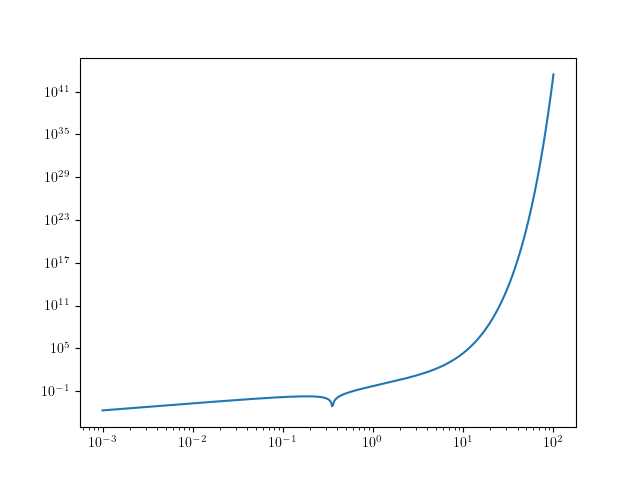

In [4]:
tau_m_arr = np.logspace(-3, 2, 500)
gamma = 2

plt.subplots()
plt.plot(tau_m_arr, np.abs(np.exp(tau_m_arr) - ((gamma+4.)/5 * tau_m_arr + 1.)))
plt.yscale('log')
plt.xscale('log')

In [13]:
from scipy.optimize import root_scalar

In [14]:
def find_tau_m(gamma):
    def func(tau):
        return (np.exp(tau) - ((gamma+4.)/5 * tau + 1.))
    res = root_scalar(func, bracket=[1e-10, 10], method='brentq')
    return res.root

find_tau_m(3.)

0.6390296264710424

<IPython.core.display.Javascript object>


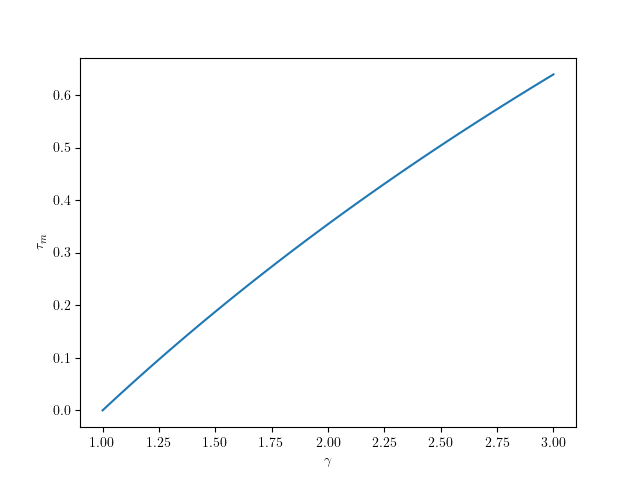

Text(0, 0.5, '$\\tau_m$')

In [15]:
plt.subplots()
gamma_arr = np.linspace(1, 3)
tau_arr = np.array([find_tau_m(gamma) for gamma in gamma_arr])
plt.plot(gamma_arr, tau_arr)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\tau_m$')

In [16]:
twopi_GHz_over_eV = 4.13357119850271e-06

In [17]:
def tau(nu, EM, Te):
    """ 
    nu: [GHz]
    EM: emission measure [cm^-6*pc]
    Te: temperature of electrons [K]
    """
    res = 6.35e17 * (EM) * Te**(-1.38) * (nu/(1e-9))**(-2.08)
    return res

tau(1, 1, 5000)

9.510319762021515e-07

In [18]:
tau(1, 0.015**2*1000, 5000)

2.139821946454841e-07

<IPython.core.display.Javascript object>


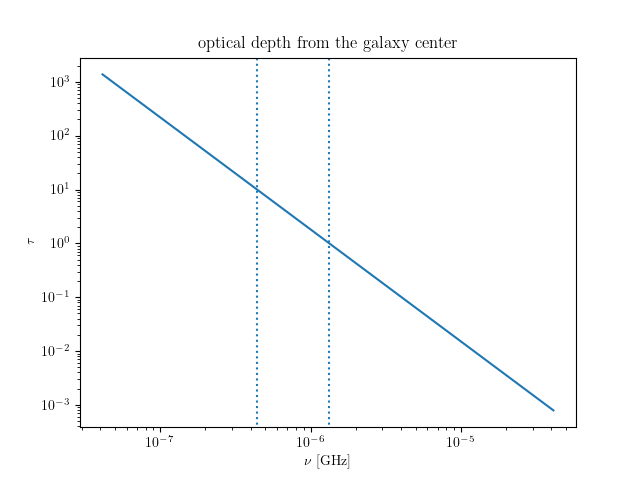

0.3226618752492872
0.10665431303534932


In [19]:
plt.subplots()
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel(r'$\tau$')
plt.title('optical depth from the galaxy center')

nu_arr = np.logspace(-2, 1)
E_arr = nu_arr * twopi_GHz_over_eV
plt.plot(E_arr, tau(nu_arr, EM=1e5, Te=5000))
y0, y1 = plt.ylim()
plt.ylim(y0, y1)

# solve
def func(nu):
    return tau(nu, EM=1e5, Te=5000)-1.
res = root_scalar(func, bracket=[1e-10, 10], method='brentq')
nu0 = res.root
print(nu0)
plt.vlines(nu0*twopi_GHz_over_eV, 1e-5, 1e5, ls=':')

# solve 2
def func(nu):
    return tau(nu, EM=1e4, Te=5000)-1.
res = root_scalar(func, bracket=[1e-10, 10], method='brentq')
nu0 = res.root
print(nu0)
plt.vlines(nu0*twopi_GHz_over_eV, 1e-5, 1e5, ls=':')

#plt.savefig('/home/chen/Dropbox/Research/axion_stim_decays/SNR_Ghost_draft/figs/optical_depth.pdf')

# Other axion constraints

In [3]:
sys.path.insert(0, '../axion_limits/')
from PlotFuncs_mod import gen_constraints

#plt.rc('text', usetex=True)
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{mathpazo}']

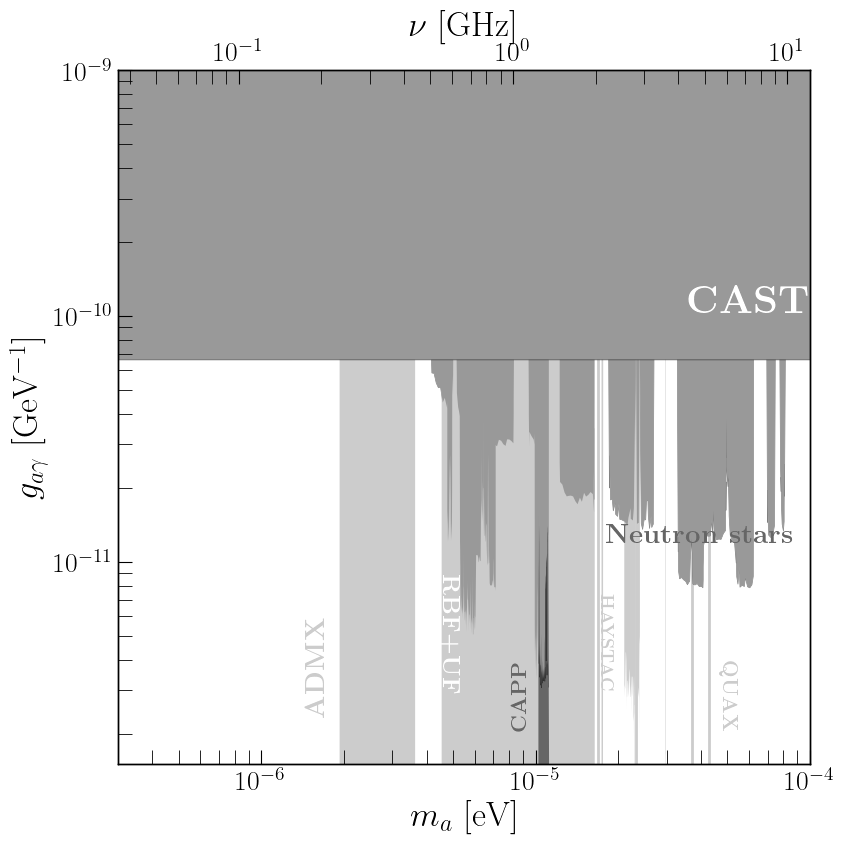

In [7]:
fig, ax = gen_constraints()
plt.tight_layout()
fig

# Single benchmarks in ($m_a, g_{a\gamma}$)

TODO: 

1. double check the formula to be used for the signal --DONE
1. check if denser DM increases or descreases the signal --DONE
1. check the $(\ell, b)$ dependence
1. make new $m_a-g_a$ contours
    1. just shift local density by some constant, say $4\times 10^4$ years
    1. increase $S_{\nu,0}$
    1. increase number of SNR's
1. refine the abberation and moving-out-of-spotlight effect    


### Example -1 (W50)

In [4]:
ct.angle_to_solid_angle(84/60/180*3.14)

0.0004684409382259073

In [91]:
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 39.7 #175 #175 #178 #10 #179 # 111.734745
latitude = -2.0 # -02.129570
D = 4.9 #0.5 #[kpc]

alpha = 0.7
gamma = ap.gamma_from_alpha(alpha)
nu_Biet = 8.
nu_pivot = 1.
t_peak = 10.*365 # 300.*365  #100 * 365
t_trans = 30.* t_peak /365
t_age = 54772.
S0 = 85. #Jy
L_today = S0 * ct._Jy_over_cgs_irrad_ * 4.*np.pi * (D*ct._kpc_over_cm_)**2
ang_size = 4.7e-4 #None #1.5e-4#None #snr_ang_size(D) #1.7e-4 #1e-6 #1e-5 #1e-4 #


source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':t_age, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma, # Cas A experiment
#                 'gamma':(2.032 * 1.3/0.7), # a detected 1.3% decay rather than 0.7%
#                 'model':'eff', 'L_today':LumCasA, 'L_peak':1.e30,
                #'model':'eff', 'L_today':LumCasA, 't_trans':10.,
                #'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans,
                'model': "eff", 'L_today': L_today, 't_peak': t_peak, 't_trans': t_trans,
                'force_Omega_disp_compute': True,
                'use_free_expansion': False
               }

ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 6.e-10 #FIXME
axion_input = rt.ax_in(ma_ref, ga_ref)

data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile,
        'correlation_mode': None #"interferometry"#"single dish"
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':0.}

### t_extra_old slices

/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:329: RuntimeWarning: invalid value encountered in true_divide
  area_dish = area/number_of_dishes
/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:394: RuntimeWarning: invalid value encountered in true_divide
  new_output['S/N_power'] = new_output['signal_power'] / \
/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:329: RuntimeWarning: invalid value encountered in true_divide
  area_dish = area/number_of_dishes
/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:394: RuntimeWarning: invalid value encountered in true_divide
  new_output['S/N_power'] = new_output['signal_power'] / \


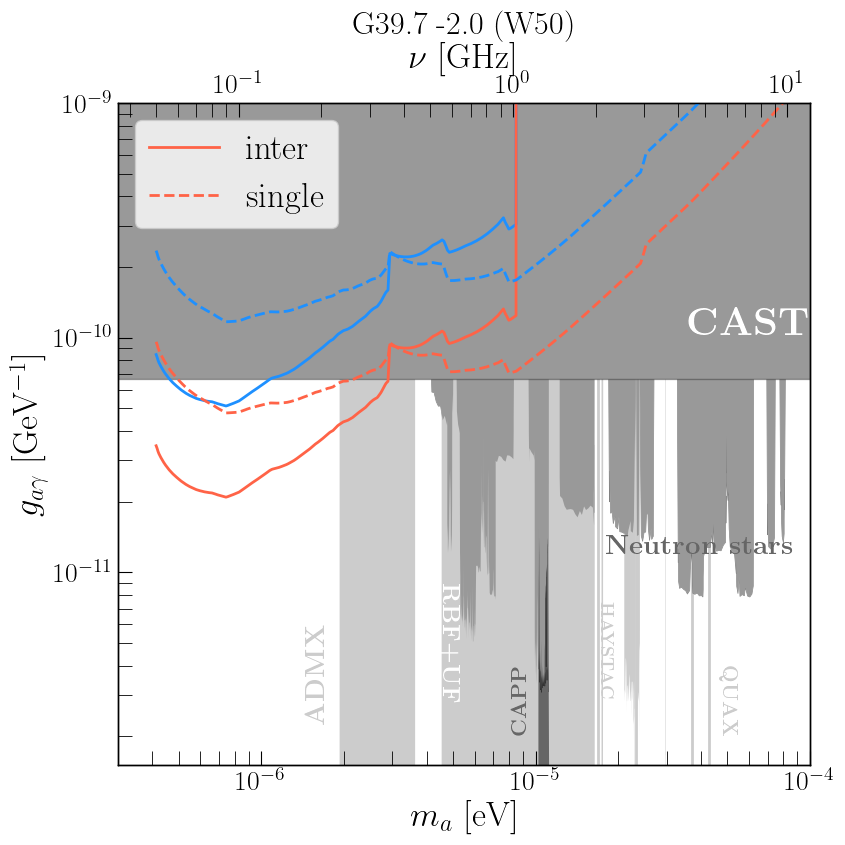

In [92]:
Nma = 501
nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)

ma_new = pt.ma_from_nu(np.concatenate((nulow, numid)))
ga_new = ga_ref
z_val = 1. #2.


#
# only adiabatic
#
source_input['use_free_expansion'] = False
data['correlation_mode'] = 'interferometry'
routine_out = {}
bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                             source_input=source_input,
                             data=data,
                             Snu_echo_kwargs=Snu_echo_kwargs)


data['correlation_mode'] = 'single dish'
routine_out = {}
bounds_out_single = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                             source_input=source_input,
                             data=data,
                             Snu_echo_kwargs=Snu_echo_kwargs)
    

    
fig, ax = gen_constraints()

ga_reach = ec.ga_reach(z_val, bounds_out['S/N_power'], bounds_out['ga'])
ma_ga = np.vstack((ma_new, ga_reach)).T
ax.plot(ma_ga[:,0], ma_ga[:,1], color='dodgerblue', alpha=1., zorder=100, linewidth=2)

ga_reach = ec.ga_reach(z_val, bounds_out_single['S/N_power'], bounds_out_single['ga'])
ma_ga = np.vstack((ma_new, ga_reach)).T
ax.plot(ma_ga[:,0], ma_ga[:,1], '--', color='dodgerblue', alpha=1., zorder=101, linewidth=2)


#
# debug
#
bounds_out_single_adiaonly = bounds_out_single

#
# add free expansion
#
source_input['use_free_expansion'] = True

data['correlation_mode'] = 'interferometry'
routine_out = {}
bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                             source_input=source_input,
                             data=data,
                             Snu_echo_kwargs=Snu_echo_kwargs)


data['correlation_mode'] = 'single dish'
routine_out = {}
bounds_out_single = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                             source_input=source_input,
                             data=data,
                             Snu_echo_kwargs=Snu_echo_kwargs)
    


ga_reach = ec.ga_reach(z_val, bounds_out['S/N_power'], bounds_out['ga'])
ma_ga = np.vstack((ma_new, ga_reach)).T
ax.plot(ma_ga[:,0], ma_ga[:,1], color='tomato', alpha=1., zorder=100, label='inter', linewidth=2) 

ga_reach = ec.ga_reach(z_val, bounds_out_single['S/N_power'], bounds_out_single['ga'])
ma_ga = np.vstack((ma_new, ga_reach)).T
ax.plot(ma_ga[:,0], ma_ga[:,1], '--', color='tomato', alpha=1., zorder=101, label='single', linewidth=2)


#
# plot text
#


# title_str = r"SNR: D={D:.3f} kpc, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, S/N={sn:.0f}, DM profile={DM_profile}, age={age} years"
# title = title_str.format(D=D,
#                  #log10Lpk=np.log10(L_peak_Biet), 
#                  log10tpk=np.log10(t_peak),
#                  ell=longitude,
#                  b=latitude,
#                  alpha=alpha,
#                  #sr=ang_size, 
#                  sn=z_val,
#                  DM_profile=DM_profile,
#                         age=source_input['t_age'])
#ax.set_title(title, fontdict={'fontsize': 17})
ax.set_title("G39.7 -2.0 (W50)", fontdict={'fontsize': 23})
#ax.set_xlim(3e-7, 1e-4)
#plt.ylim(1e-12, 1e-9)
ax.legend(loc=2)
fig.tight_layout()
plt.savefig('../plots/W50.pdf')

fig

### Example 0 (W28 like) 

benchmark A

In [105]:
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 64 #175 #175 #178 #10 #179 # 111.734745
latitude = -0.1 # -02.129570
D = 1.8 #0.5 #[kpc]

alpha = 0.6
gamma = ap.gamma_from_alpha(alpha)
nu_Biet = 8.
nu_pivot = 1.
t_trans = 100.
t_peak = t_trans/30*365
t_age = 35000.
S0 = 310 #Jy
L_today = S0 * ct._Jy_over_cgs_irrad_ * 4.*np.pi * (D*ct._kpc_over_cm_)**2
ang_size = 1.5e-4 #None #1.5e-4#None #snr_ang_size(D) #1.7e-4 #1e-6 #1e-5 #1e-4 #


source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':t_age, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma, 
                'model': "eff", 'L_today': L_today, 't_peak': t_peak, 't_trans': t_trans,
                'force_Omega_disp_compute': True,
                'use_free_expansion': False#True # False
               }

ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)

data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile,
        'correlation_mode': "interferometry"#"single dish"
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':0.}


#
# run it
#
Nma = 501
nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)

ma_new = pt.ma_from_nu(np.concatenate((nulow, numid)))
ga_new = ga_ref


routine_out = {}
bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                             source_input=source_input,
                             data=data,
                             Snu_echo_kwargs=Snu_echo_kwargs)


data['correlation_mode'] = 'single dish'
routine_out = {}
bounds_out_single = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                             source_input=source_input,
                             data=data,
                             Snu_echo_kwargs=Snu_echo_kwargs)
    


/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:329: RuntimeWarning: invalid value encountered in true_divide
  area_dish = area/number_of_dishes
/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:394: RuntimeWarning: invalid value encountered in true_divide
  new_output['S/N_power'] = new_output['signal_power'] / \


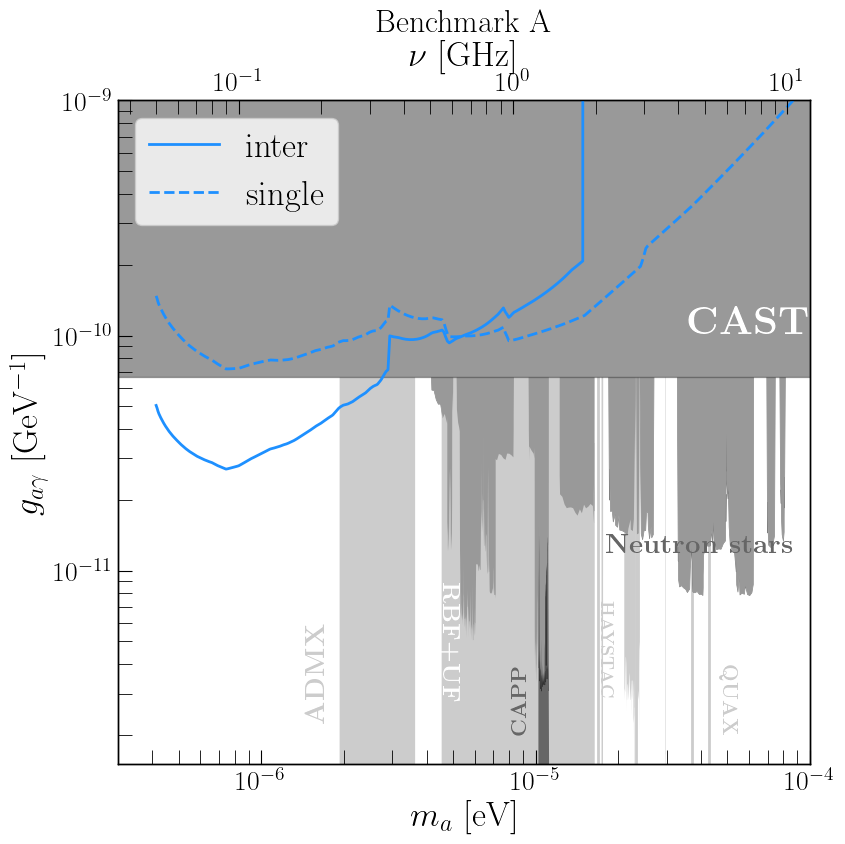

In [106]:
fig, ax = gen_constraints()

ghosh = np.loadtxt("../data/cygA_bounds.csv", delimiter=",")
z_val = 1. #2.


ga_reach = ec.ga_reach(z_val, bounds_out['S/N_power'], bounds_out['ga'])
ma_ga = np.vstack((ma_new, ga_reach)).T
ax.plot(ma_ga[:,0], ma_ga[:,1], color='dodgerblue', alpha=1., zorder=100, label='inter', linewidth=2) 
#ax.plot(ma_ga[:,0], ma_ga[:,1], color='salmon', alpha=1., zorder=100, label='inter', linewidth=2) 

ga_reach = ec.ga_reach(z_val, bounds_out_single['S/N_power'], bounds_out_single['ga'])
ma_ga = np.vstack((ma_new, ga_reach)).T
ax.plot(ma_ga[:,0], ma_ga[:,1], '--', color='dodgerblue', alpha=1., zorder=101, label='single', linewidth=2)
#ax.plot(ma_ga[:,0], ma_ga[:,1], '--', color='salmon', alpha=1., zorder=101, label='single', linewidth=2)


#ax.text(3e-5, 3e-10, r"{\bf SNR}", fontdict={'size':25}, color='w', zorder=101)


title_str = r"SNR: D={D:.3f} kpc, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, S/N={sn:.0f}, DM profile={DM_profile}, age={age} years"
title = title_str.format(D=D,
                 #log10Lpk=np.log10(L_peak_Biet), 
                 log10tpk=np.log10(t_peak),
                 ell=longitude,
                 b=latitude,
                 alpha=alpha,
                 #sr=ang_size, 
                 sn=z_val,
                 DM_profile=DM_profile,
                        age=source_input['t_age'])

#ax.set_title(title, fontdict={'fontsize': 17})
ax.set_title("Benchmark A", fontdict={'fontsize': 23})
#plt.xlim(3e-7, 1e-4)
#plt.ylim(1e-13, 1e-9)
ax.legend(loc=2)
fig.tight_layout()
#plt.savefig('../plots/projection_old_logLpk_%.1f_logtpk_%.1f_ell_%.1f_b_%.1f_snr_%d_D_%.1f_alpha_%.1f_%s.png' %(0, np.log10(t_peak), longitude, latitude, z_val, D, alpha, DM_profile))
#plt.savefig('../plots/projection_W28_adia.pdf')
plt.savefig('../plots/SNR-A.pdf')
#plt.savefig('../plots/projection_W28.pdf')

fig

benchmark B

In [107]:
source_input['use_free_expansion'] = True
#
# run it
#
Nma = 501
nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)

ma_new = pt.ma_from_nu(np.concatenate((nulow, numid)))
ga_new = ga_ref


data['correlation_mode'] = 'interferometry'
routine_out = {}
bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                             source_input=source_input,
                             data=data,
                             Snu_echo_kwargs=Snu_echo_kwargs)


data['correlation_mode'] = 'single dish'
routine_out = {}
bounds_out_single = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                             source_input=source_input,
                             data=data,
                             Snu_echo_kwargs=Snu_echo_kwargs)
    


/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:329: RuntimeWarning: invalid value encountered in true_divide
  area_dish = area/number_of_dishes
/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:394: RuntimeWarning: invalid value encountered in true_divide
  new_output['S/N_power'] = new_output['signal_power'] / \


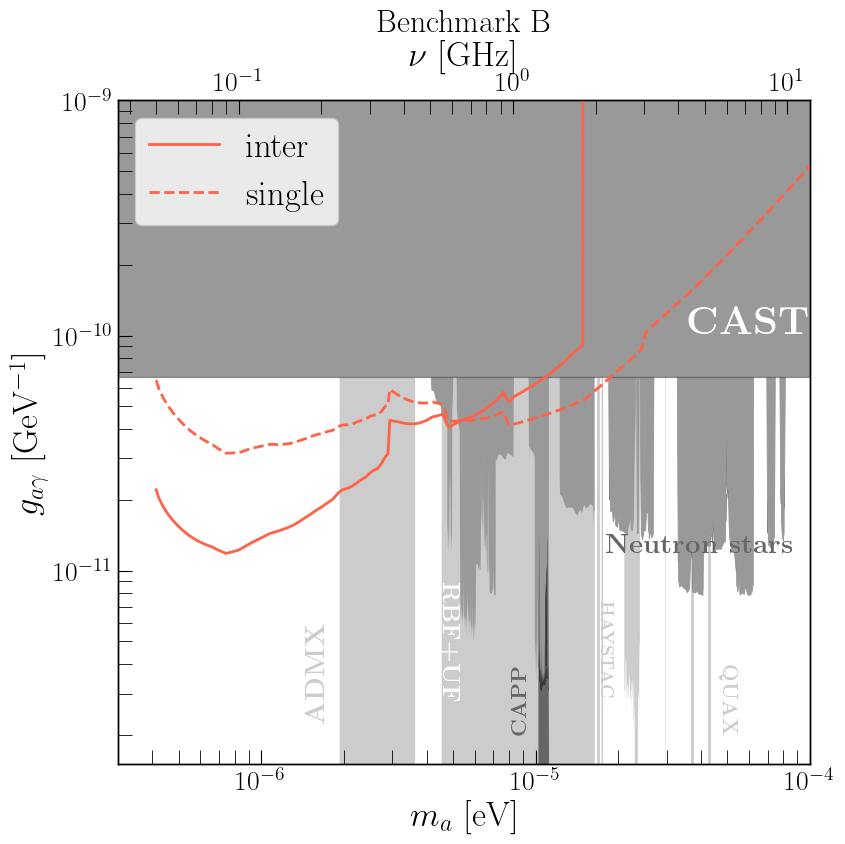

In [108]:
fig, ax = gen_constraints();

ghosh = np.loadtxt("../data/cygA_bounds.csv", delimiter=",")
z_val = 1. #2.


ga_reach = ec.ga_reach(z_val, bounds_out['S/N_power'], bounds_out['ga'])
ma_ga = np.vstack((ma_new, ga_reach)).T
#ax.plot(ma_ga[:,0], ma_ga[:,1], color='dodgerblue', alpha=1., zorder=100, label='inter') 
ax.plot(ma_ga[:,0], ma_ga[:,1], color='tomato', alpha=1., zorder=100, label='inter', linewidth=2) 

ga_reach = ec.ga_reach(z_val, bounds_out_single['S/N_power'], bounds_out_single['ga'])
ma_ga = np.vstack((ma_new, ga_reach)).T
#ax.plot(ma_ga[:,0], ma_ga[:,1], '--', color='dodgerblue', alpha=1., zorder=101, label='single')
ax.plot(ma_ga[:,0], ma_ga[:,1], '--', color='tomato', alpha=1., zorder=101, label='single', linewidth=2)


#ax.text(3e-5, 3e-10, r"{\bf SNR}", fontdict={'size':25}, color='w', zorder=101)


title_str = r"SNR: D={D:.3f} kpc, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, S/N={sn:.0f}, DM profile={DM_profile}, age={age} years"
title = title_str.format(D=D,
                 #log10Lpk=np.log10(L_peak_Biet), 
                 log10tpk=np.log10(t_peak),
                 ell=longitude,
                 b=latitude,
                 alpha=alpha,
                 #sr=ang_size, 
                 sn=z_val,
                 DM_profile=DM_profile,
                        age=source_input['t_age'])

#ax.set_title(title, fontdict={'fontsize': 17})
ax.set_title("Benchmark B", fontdict={'fontsize': 23})
#plt.xlim(3e-7, 1e-4)
#plt.ylim(1e-13, 1e-9)
ax.legend(loc=2)
fig.tight_layout()
#plt.savefig('../plots/projection_old_logLpk_%.1f_logtpk_%.1f_ell_%.1f_b_%.1f_snr_%d_D_%.1f_alpha_%.1f_%s.png' %(0, np.log10(t_peak), longitude, latitude, z_val, D, alpha, DM_profile))
#plt.savefig('../plots/projection_W28_adia.pdf')
plt.savefig('../plots/SNR-B.pdf')

fig

In [109]:
ct.angle_to_solid_angle(48 * ct._arcmin_over_radian_)

0.00015311679381005744

In [110]:
# check light curve
t_arr = np.logspace(np.log10(t_peak/365/10), np.log10(t_age), 200)
plt.subplots()
plt.plot(t_arr, ap.L_source(t_arr, **source_input))
plt.xscale('log')
plt.yscale('log')

In [409]:
print('%.1e cgs' %(ap.L_source(t_peak/365, **source_input)))

1.4e+30 cgs


In [394]:
print('%.1e cgs' %(ap.L_source(t_trans, **source_input)))

3.6e+28 cgs


In [385]:
print('%.1e Jy' %(ap.L_source(t_age, **source_input) / (4.*np.pi * (D * ct._kpc_over_cm_)**2) / ct._Jy_over_cgs_irrad_))

3.1e+02 Jy


In [160]:
ap.gamma_from_alpha(0.6)

1.7600000000000002

In [159]:
ap.gamma_from_alpha(0.7)

1.92

In [48]:
pt.ma_from_nu(0.3)

2.481400683498048e-06

In [10]:
ap.T_sys(1., Tr=40)

array(48.01995325)

In [11]:
ap.T_sys(1., Tbg_at_408=461, Tr=40)

array(84.90116469)

In [50]:
ap.bg_408_temp(l=-6.4, b=0.1, size=1.5e-4, average=True, verbose=False)  # [K]

array(461.2647, dtype=float32)

### Example 1

In [115]:
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 175. #175 #175 #178 #10 #179 # 111.734745
latitude = 0. # -02.129570
D = 0.5 #0.5 #[kpc]

alpha = 0.5
gamma = ap.gamma_from_alpha(alpha)
nu_Biet = 8.
nu_pivot = 1.
L_peak_Biet = 10**(25.5+1.6*2.)
L_peak = L_peak_Biet * (nu_Biet/nu_pivot) ** alpha
t_peak = 10**1.7
t_trans = t_peak * 30./365
ang_size = None 


source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':1e4, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma, 
                'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans,
                'force_Omega_disp_compute': True
               }

ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)

data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile,
        'correlation_mode': "interferometry"#"interferometry"#"single dish"        
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':None}


#
# run it
#
# add in t extra

Nma = 501
nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)

ma_new = pt.ma_from_nu(np.concatenate((nulow, numid)))
ga_new = ga_ref

res_dct = {}
t_extra_old_arr = [4.5e4]
for t_extra_old in t_extra_old_arr:
    Snu_echo_kwargs['t_extra_old'] = t_extra_old
    routine_out = {}
    bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                                 source_input=source_input,
                                 data=data,
                                 Snu_echo_kwargs=Snu_echo_kwargs)
    res_dct[str(int(t_extra_old))] = bounds_out


data['correlation_mode'] = 'single dish'    
for t_extra_old in t_extra_old_arr:
    Snu_echo_kwargs['t_extra_old'] = t_extra_old
    routine_out = {}
    bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                                 source_input=source_input,
                                 data=data,
                                 Snu_echo_kwargs=Snu_echo_kwargs)
    res_dct[str(int(t_extra_old))+"single"] = bounds_out    


/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:329: RuntimeWarning: invalid value encountered in true_divide
  area_dish = area/number_of_dishes
/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:394: RuntimeWarning: invalid value encountered in true_divide
  new_output['S/N_power'] = new_output['signal_power'] / \


SNR: D=0.500 kpc, Lpk=10$^{28.7}$, tpk=10$^{1.7}$,\\$\ell$=175.0,$b$=0.0, $\alpha$=0.5, S/N=1, DM profile=NFW, age=55000.0 years


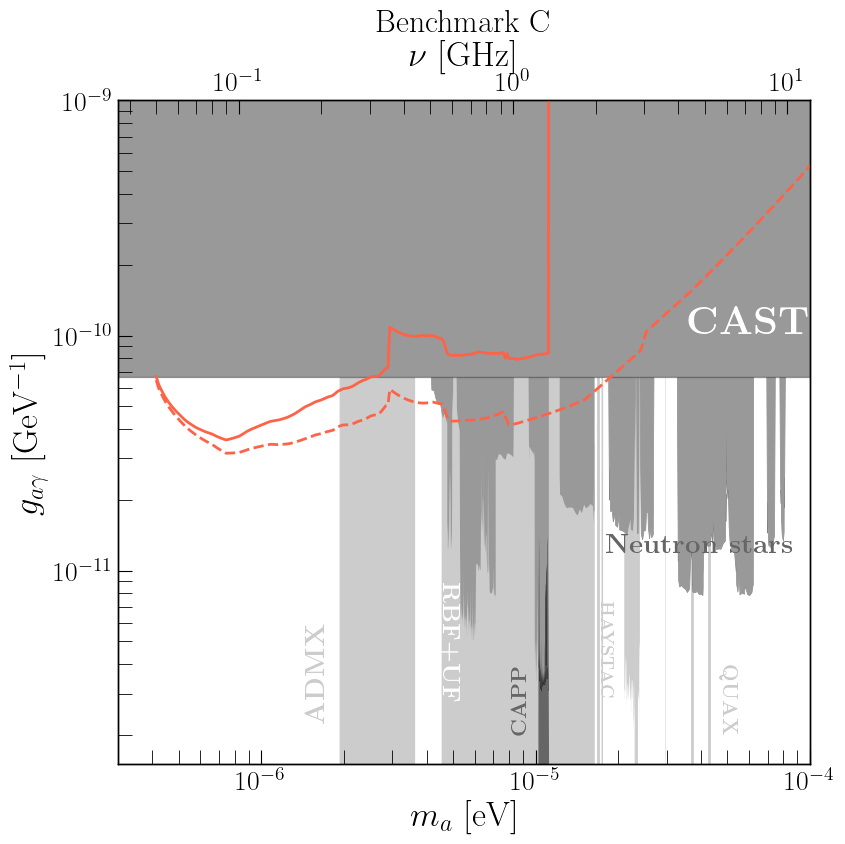

In [116]:
fig, ax = gen_constraints();

z_val = 1.
#ghosh = np.loadtxt("../data/cygA_bounds.csv", delimiter=",")
# plt.subplots()
# plt.xlabel('$m_a$ [eV]')
# plt.ylabel('$g_{a\gamma\gamma}$ [GeV$^{-1}$]')
# plt.axhline(6.e-11, color='k', ls=':')

# existing echo bounds
# ax.plot(ghosh[:,0], ghosh[:,1]*sqrt(z_val), color=[0.5,0.5,0.5], ls='--')


for key in t_extra_old_arr: #res_dct.keys():
    key = str(int(key))
    bounds_out = res_dct[key]
    

    ga_reach = ec.ga_reach(z_val, bounds_out['S/N_power'], bounds_out['ga'])
    ma_ga = np.vstack((ma_new, ga_reach)).T
    #ax.fill_between(ma_ga[:,0], ma_ga[:,1], 1., color='forestgreen', alpha=0.5, zorder=100, label='interferometry') 
    ax.plot(ma_ga[:,0], ma_ga[:,1], color='tomato', alpha=1., zorder=100, label='inter', linewidth=2) 

    ga_reach = ec.ga_reach(z_val, bounds_out_single['S/N_power'], bounds_out_single['ga'])
    ma_ga = np.vstack((ma_new, ga_reach)).T
    #ax.fill_between(ma_ga[:,0], ma_ga[:,1], 1., color='salmon', alpha=0.5, zorder=101, label='single dish mode')
    ax.plot(ma_ga[:,0], ma_ga[:,1], '--', color='tomato', alpha=1., zorder=101, label='single', linewidth=2)
    
    


title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, S/N={sn:.0f}, DM profile={DM_profile}, age={age} years"
title = title_str.format(D=D,
                 log10Lpk=np.log10(L_peak_Biet), 
                 log10tpk=np.log10(t_peak),
                 ell=longitude,
                 b=latitude,
                 alpha=alpha,
                 #sr=ang_size, 
                 sn=z_val,
                 DM_profile=DM_profile,
                        age=source_input['t_age']+t_extra_old_arr[0])

print(title)
ax.set_title('Benchmark C', fontdict={'fontsize': 23})
#ax.legend(loc=2)
#plt.xlim(3e-7, 1e-4)
fig.tight_layout()
#plt.savefig('../plots/projection_old_logLpk_%.1f_logtpk_%.1f_ell_%.1f_b_%.1f_snr_%d_D_%.1f_alpha_%.1f_%s_tex_%.0f.png' %(np.log10(L_peak), np.log10(t_peak), longitude, latitude, z_val, D, alpha, DM_profile, t_extra_old_arr[0]))
plt.savefig('../plots/SNR-C.pdf')

fig

In [117]:
# cross checks

In [240]:
L_peak_Biet = 10**(25.5+1.6*2.)
L_peak = L_peak_Biet * (nu_Biet/nu_pivot) ** alpha
L_peak

1.4175715661678806e+29

In [190]:
10**1.7 * 30 /365

4.119347125703608

In [189]:
ap.gamma_from_alpha(0.5)

1.6

In [396]:
10**(25.5+1.6*2.)
10**(25.5+1.6*2.) * (nu_Biet/nu_pivot) ** alpha

1.7452353142041894e+29

In [287]:
ap.L_source(t_age, **source_input) / (4.*np.pi * (D * ct._kpc_over_cm_)**2) / ct._Jy_over_cgs_irrad_

47.1474556745626

In [118]:
snr_size = ec.Omega_size(source_input)
print("The SNR size is %.2e sr," %snr_size)
print("which is %.1f arcmin" %(ct.solid_angle_to_angle(snr_size) / ct._arcmin_over_radian_))

The SNR size is 1.76e-05 sr,
which is 16.3 arcmin


<IPython.core.display.Javascript object>


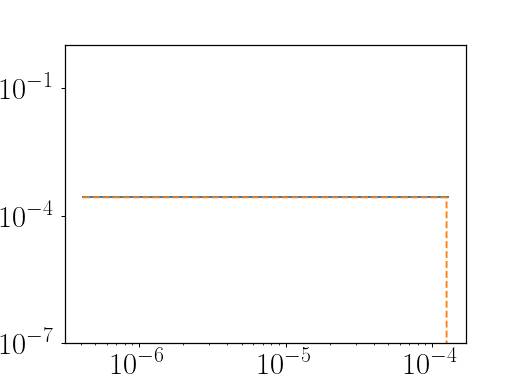

(1e-07, 1)

In [291]:
plt.subplots()
plt.plot(bounds_out['ma'], bounds_out['noise_Omega_obs'])
plt.plot(bounds_out['ma'], bounds_out['noise_Omega_res'] , '--')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-7, 1)

<IPython.core.display.Javascript object>


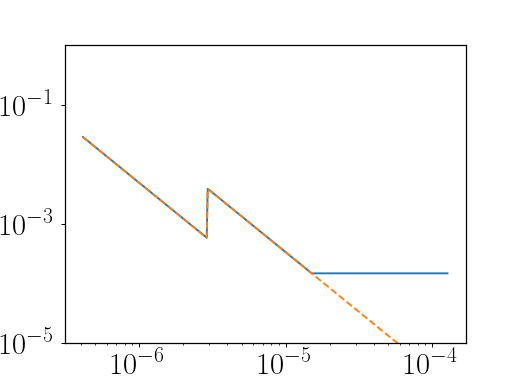

(1e-05, 1)

In [289]:
plt.subplots()
plt.plot(bounds_out_single['ma'], bounds_out_single['noise_Omega_obs'])
plt.plot(bounds_out_single['ma'], bounds_out_single['noise_Omega_res'],  '--')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 1)

In [171]:
ct.solid_angle_to_angle(bounds_out_single['noise_Omega_obs'][-1])/np.pi*180*60

47.50895038319685

In [164]:
bounds_out_single.keys()

dict_keys(['echo_Snu', 'signal_nu', 'signal_delnu', 'signal_Omega', 'signal_Snu', 'signal_S_echo', 'signal_Tant', 'signal_power', 'noise_nu', 'noise_delnu', 'noise_Omega_res', 'noise_Omega_obs', 'noise_T408', 'noise_Tsys', 'noise_Trms', 'noise_power', 'S/N_power', 'S/N_temp', 'ma', 'ga'])

### Example 2

In [113]:
DM_profile = "NFW" #"Burkert" # "NFW"
longitude = 90. #175 #175 #178 #10 #179 # 111.734745
latitude = 0. # -02.129570
D = 0.5 #0.5 #[kpc]

alpha = 0.5
gamma = ap.gamma_from_alpha(alpha)
nu_Biet = 8.
nu_pivot = 1.
L_peak_Biet = 10**(25.5+1.6*2.)
L_peak = L_peak_Biet * (nu_Biet/nu_pivot) ** alpha
#L_peak = 10**(25.5+1.6*2.)
t_peak = 10**1.7
t_trans = t_peak * 30./365
ang_size = None #snr_ang_size(D) #1.7e-4 #1e-6 #1e-5 #1e-4 #


source_input = {'longitude':longitude,
                'latitude':latitude, 
                'distance':D, 
                'size':ang_size,
                't_age':10, #1e4, 
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma,
                'model': "eff", 'L_peak': L_peak, 't_peak': t_peak, 't_trans': t_trans,
                'force_Omega_disp_compute': True
               }

ma_ref, ga_ref = pt.ma_from_nu(source_input['nu_pivot']), 1.e-10
axion_input = rt.ax_in(ma_ref, ga_ref)

data = {'deltaE_over_E':ct._deltaE_over_E_,
        'f_Delta':ct._f_Delta_,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0,
        'DM_profile': DM_profile,
        'correlation_mode': "interferometry"#"single dish"#"interferometry"        
       }

t_peak = source_input['t_peak']
t_age = source_input['t_age']

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(t_age)+1),
                   't_extra_old':None}

#
# run it
#
# no t extra

Nma = 501
nulow = np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), Nma//2)
numid = np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), Nma - Nma//2)

ma_new = pt.ma_from_nu(np.concatenate((nulow, numid)))
ga_new = ga_ref

res_dct = {}
t_extra_old_arr = [0]
#t_extra_old_arr = [4e4]
for t_extra_old in t_extra_old_arr:
    Snu_echo_kwargs['t_extra_old'] = t_extra_old
    #print(Snu_echo_kwargs)
    routine_out = {}
    bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                                 source_input=source_input,
                                 data=data,
                                 Snu_echo_kwargs=Snu_echo_kwargs)
    res_dct[str(int(t_extra_old))] = bounds_out


data['correlation_mode'] = 'single dish'    
for t_extra_old in t_extra_old_arr:
    Snu_echo_kwargs['t_extra_old'] = t_extra_old
    routine_out = {}
    bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                                 source_input=source_input,
                                 data=data,
                                 Snu_echo_kwargs=Snu_echo_kwargs)
    res_dct[str(int(t_extra_old))+"single"] = bounds_out    


/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:329: RuntimeWarning: invalid value encountered in true_divide
  area_dish = area/number_of_dishes
/home/chen/Code/axion_laser/github/workspace_notebooks/../routines.py:394: RuntimeWarning: invalid value encountered in true_divide
  new_output['S/N_power'] = new_output['signal_power'] / \


SNR: D=0.500 kpc, Lpk=10$^{28.7}$, tpk=10$^{1.7}$,\\$\ell$=90.0,$b$=0.0, $\alpha$=0.5, S/N=1, DM profile=NFW, age=10 years


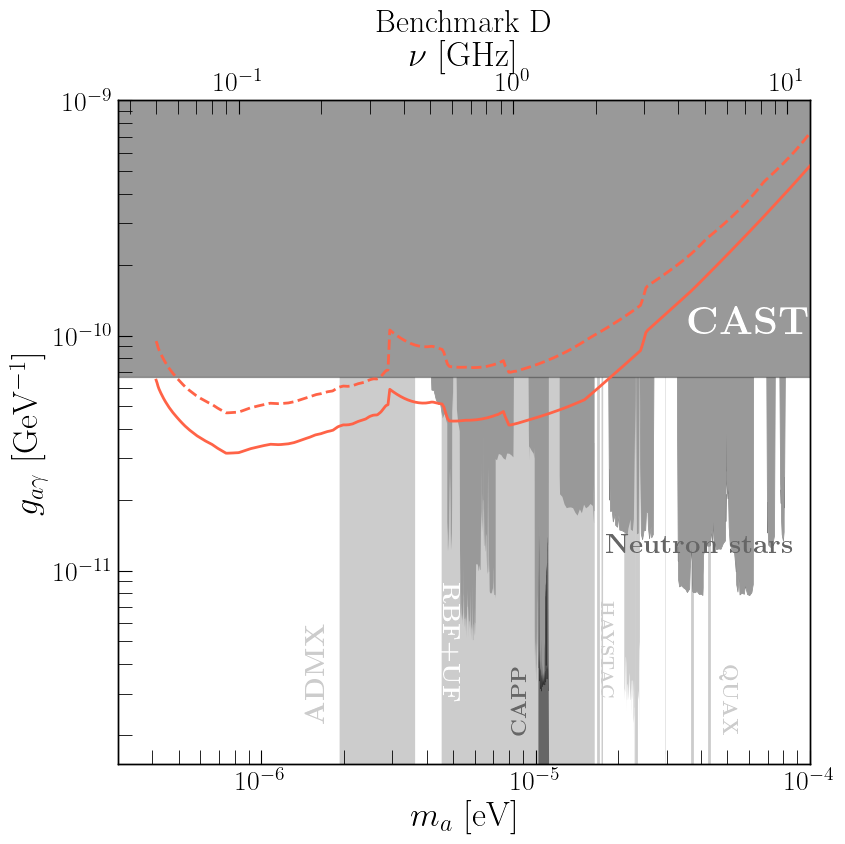

In [114]:
fig, ax = gen_constraints();

ghosh = np.loadtxt("../data/cygA_bounds.csv", delimiter=",")
z_val = 1.
# plt.subplots()
# plt.xlabel('$m_a$ [eV]')
# plt.ylabel('$g_{a\gamma\gamma}$ [GeV$^{-1}$]')
# plt.axhline(6.e-11, color='k', ls=':')

# existing echo bounds
# ax.plot(ghosh[:,0], ghosh[:,1]*sqrt(z_val), color=[0.5,0.5,0.5], ls='--')


for key in t_extra_old_arr: #res_dct.keys():
    key = str(int(key))
    bounds_out = res_dct[key]
    

    ga_reach = ec.ga_reach(z_val, bounds_out['S/N_power'], bounds_out['ga'])
    ma_ga = np.vstack((ma_new, ga_reach)).T
    #ax.fill_between(ma_ga[:,0], ma_ga[:,1], 1., color='forestgreen', alpha=0.5, zorder=100, label='interferometry') 
    ax.plot(ma_ga[:,0], ma_ga[:,1], '--', color='tomato', alpha=1., zorder=100, label='inter', linewidth=2) 

    ga_reach = ec.ga_reach(z_val, bounds_out_single['S/N_power'], bounds_out_single['ga'])
    ma_ga = np.vstack((ma_new, ga_reach)).T
    #ax.fill_between(ma_ga[:,0], ma_ga[:,1], 1., color='salmon', alpha=0.5, zorder=101, label='single dish mode')
    ax.plot(ma_ga[:,0], ma_ga[:,1], color='tomato', alpha=1., zorder=101, label='single', linewidth=2)
    
#     ga_reach = ec.ga_reach(z_val, bounds_out['S/N'], bounds_out['ga'])
#     ma_ga = np.vstack((ma_new, ga_reach)).T
#     #ax.loglog(ma_ga[:,0], ma_ga[:,1], label='%s' %key)
#     ax.fill_between(ma_ga[:,0], ma_ga[:,1], 1., color='forestgreen', alpha=0.5, zorder=100, label='interferometry')


#     bounds_out_single = res_dct[key+"single"]
#     ga_reach = ec.ga_reach(z_val, bounds_out_single['S/N'], bounds_out_single['ga'])
#     ma_ga = np.vstack((ma_new, ga_reach)).T
#     #ax.loglog(ma_ga[:,0], ma_ga[:,1], label='%s' %key)
#     ax.fill_between(ma_ga[:,0], ma_ga[:,1], 1., color='salmon', alpha=0.5, zorder=100, label='single dish mode')
        
# ax.text(3e-5, 3e-10, r"{\bf SNR}", fontdict={'size':25}, color='w', zorder=101)
# ax.set_xscale("log");ax.set_yscale("log");
#ax.set_ylim(1.e-13, 1.e-8);
#ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.), ncol=len(t_extra_old_arr), prop={'size': 10})
#ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.), ncol=1, prop={'size': 10})


title_str = r"SNR: D={D:.3f} kpc, Lpk=10$^{{{log10Lpk:.1f}}}$, tpk=10$^{{{log10tpk:.1f}}}$,\\$\ell$={ell:.1f},$b$={b:.1f}, $\alpha$={alpha:.1f}, S/N={sn:.0f}, DM profile={DM_profile}, age={age} years"
title = title_str.format(D=D,
                 log10Lpk=np.log10(L_peak_Biet), 
                 log10tpk=np.log10(t_peak),
                 ell=longitude,
                 b=latitude,
                 alpha=alpha,
                 #sr=ang_size, 
                 sn=z_val,
                 DM_profile=DM_profile,
                        age=source_input['t_age']+t_extra_old_arr[0])

#ax.set_title(title, fontdict={'fontsize': 17})
ax.set_title('Benchmark D', fontdict={'fontsize': 23})
#ax.legend(loc=2)
#plt.xlim(3e-7, 1e-4)
fig.tight_layout()
#plt.savefig('../plots/projection_old_logLpk_%.1f_logtpk_%.1f_ell_%.1f_b_%.1f_snr_%d_D_%.1f_alpha_%.1f_%s_tex_%.0f.png' %(np.log10(L_peak), np.log10(t_peak), longitude, latitude, z_val, D, alpha, DM_profile, t_extra_old_arr[0]))
plt.savefig('../plots/SNR-D.pdf')

print(title)
fig

In [366]:
10**1.7/365 * 30

4.119347125703607

In [363]:
# S0 today
print('%.1e Jy' %(ap.L_source(t_age, **source_input) / (4.*np.pi * (D * ct._kpc_over_cm_)**2) / ct._Jy_over_cgs_irrad_))

3.0e+06 Jy


In [364]:
print('%.1e Jy' %(ap.L_source(t_peak/365, **source_input) / (4.*np.pi * (D * ct._kpc_over_cm_)**2) / ct._Jy_over_cgs_irrad_))

4.7e+08 Jy


In [371]:
# size
snr_size = ec.Omega_size(source_input)
print("The SNR size is %.2e sr," %snr_size)
print("which is %.1f arcmin" %(ct.solid_angle_to_angle(snr_size) / ct._arcmin_over_radian_))

The SNR size is 6.99e-08 sr,
which is 1.0 arcmin


<IPython.core.display.Javascript object>


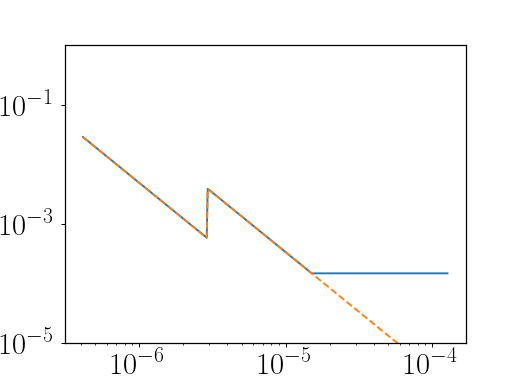

(1e-05, 1)

In [274]:
plt.subplots()
plt.plot(bounds_out_single['ma'], bounds_out_single['noise_Omega_obs'])
plt.plot(bounds_out_single['ma'], bounds_out_single['noise_Omega_res'] , '--')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 1)

<IPython.core.display.Javascript object>


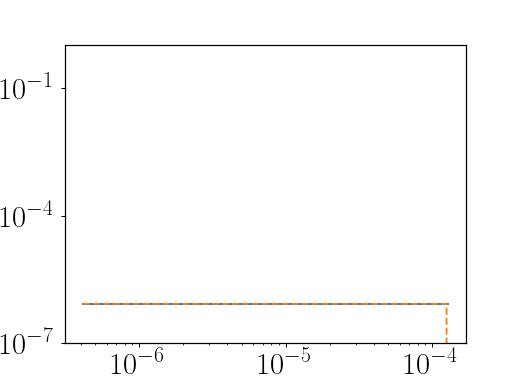

(1e-07, 1)

In [295]:
plt.subplots()
plt.plot(bounds_out['ma'], bounds_out['noise_Omega_obs'])
plt.plot(bounds_out['ma'], bounds_out['noise_Omega_res'] , '--')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-7, 1)

In [175]:
ct.solid_angle_to_angle(bounds_out_single['noise_Omega_obs'][-1])/np.pi*180*60

47.50895038319685

In [76]:
ct.angle_to_solid_angle(5e4/2/ct._kpc_over_lightyear_ *1e-3/0.5)

0.00018457365090641256

In [77]:
ec.Omega_dispersion(source_input, data, verbose=1)

sigma_v: 5.2e-04
x_offset: 0.0e+00
theta sig: 1.0e-03
Omega sig: 8.5e-07



(8.539305647528063e-07, 4.272638910060574e-12)

Plot out the noise vs $\Omega_{signal}$

<IPython.core.display.Javascript object>


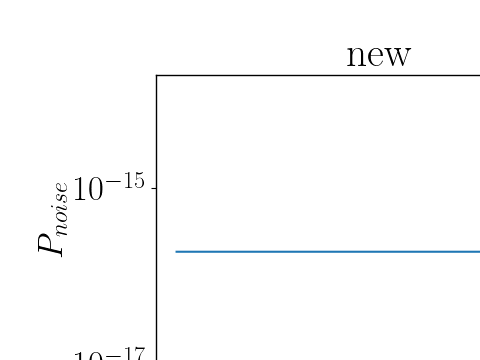

In [13]:
Omega_sig_arr = np.logspace(-9, -2)
exper_mode = sk.SKA_exper_nu(nu=1)
_, _, _, _, Omega_res, _, _ = sk.SKA_specs(nu=1, exper_mode=exper_mode, correlation_mode='single dish')
pnoise_arr = ap.P_noise(T_sys=100, delnu=1e-3, tobs=100, Omega_obs=Omega_sig_arr, Omega_res=Omega_res, nu=1, correlation_mode='single dish')
plt.subplots()
plt.plot(Omega_sig_arr, pnoise_arr)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-17,2e-14)
plt.xlabel(r'$\Omega_{sig}$')
plt.ylabel(r"$P_{noise}$")
plt.title('new')
plt.tight_layout()

# Slicing

### special slices

Every below requires running run_custom.py to generate the data file first.

In [325]:
class Container():
    pass

# when a direction is scanned over, 
# the conflicting params are not loaded

rn.args = Container()

# run:
rn.args.Nsteps = 20
rn.args.verbose = 0

# SNR:
rn.args.t_signal = 1e4#30
rn.args.S0 = 1e5
rn.args.t_extra = 4e4
rn.args.coords = (90, 0)#(175, 0)
rn.args.distance = 0.5
rn.args.sr = None
rn.args.alpha = 0.5

# light curve
rn.args.tt_ratio = 30
rn.args.nuB = 8
rn.args.Lpk = 10**(ct._mu_log10_Lpk_ + 2.*ct._sig_log10_Lpk_)
rn.args.tpk = 10**(ct._mu_log10_tpk_ + 0.*ct._sig_log10_tpk_)


# run with param_slice, i.e. no file save. result will be inside param_slice
# param_slice = rn.gen_slice("Lpk-tpk")
# param_slice.scan()
# param_slice.__dict__

# # independent run
# run = rn.Run()
# rec_dct = run('Lpk-tpk')
# rec_dct = run('tsig-r')
# rec_dct = run('tex-r')
# rec_dct = run('l-D')
# rec_dct = run('l-b')
# rec_dct = run('t-D')
# rec_dct = run('l-t')
# rec_dct = run('t-b')
# rec_dct = run('t-S0')

In [323]:
from multiprocessing import Pool

mode_arr = ['Lpk-tpk', 'tsig-r', 'tex-r', 'l-D', 'l-b', 't-D', 'l-t', 't-b', 't-S0']
run = rn.Run()

with Pool() as p:
    res_arr = p.map(run, mode_arr)

rec_dct3 = {}
for entry in res_arr:
    rec_dct3.update(entry)
    
rec_dct3

tsig-r:8dadff05-141c-4cb4-bfc0-edc7290f18b3
tex-r:6cc96432-9163-42c4-9d9e-afa89f532135
l-b:b8be34d4-1b8e-485e-a4f0-a5006b42076b
l-t:b1354254-919e-4253-9f43-1f0ca9f41085
t-D:6efc640c-c360-4efe-a452-f578fcc6949b
l-D:2080a80a-f4d7-4222-9b38-4469b99246c2
Lpk-tpk:920fe8db-87ac-4a2e-a41d-f28f56ad93b2







t-b:0ca127c4-f3f0-41c3-bfde-d47dd6c7e398


  0%|          | 0/462 [00:00<?, ?it/s]

 95%|█████████▌| 440/462 [00:06<00:00, 71.09it/s]

t-S0:6bcdec6d-b200-41a7-8ed7-4349e65b020f



100%|██████████| 462/462 [00:05<00:00, 80.76it/s]


{'Lpk-tpk': '920fe8db-87ac-4a2e-a41d-f28f56ad93b2',
 'tsig-r': '8dadff05-141c-4cb4-bfc0-edc7290f18b3',
 'tex-r': '6cc96432-9163-42c4-9d9e-afa89f532135',
 'l-D': '2080a80a-f4d7-4222-9b38-4469b99246c2',
 'l-b': 'b8be34d4-1b8e-485e-a4f0-a5006b42076b',
 't-D': '6efc640c-c360-4efe-a452-f578fcc6949b',
 'l-t': 'b1354254-919e-4253-9f43-1f0ca9f41085',
 't-b': '0ca127c4-f3f0-41c3-bfde-d47dd6c7e398',
 't-S0': '6bcdec6d-b200-41a7-8ed7-4349e65b020f'}

In [326]:
from multiprocessing import Pool

mode_arr = ['Lpk-tpk', 'tsig-r', 'tex-r', 'l-D', 'l-b', 't-D', 'l-t', 't-b', 't-S0']
run = rn.Run()

with Pool() as p:
    res_arr = p.map(run, mode_arr)

rec_dct2 = {}
for entry in res_arr:
    rec_dct2.update(entry)
    
rec_dct2

Lpk-tpk:904e0d55-5f14-4f4c-94d2-7fcf434c92e6
tex-r:71ed0e34-f669-49bd-b74b-25464d1a67ba
l-D:b88f4ced-293a-4260-a328-0ffcb8a6d5a3
l-b:7af628bf-cc8c-431b-a004-8450487ff936
tsig-r:eb71ec64-a15a-410f-824d-7eb98bf84e16
l-t:6a69ffa2-e7fe-4f8d-a566-e51b7aa4e6f0



t-b:c3cc2459-5191-44c2-ae77-175f508b265f

t-D:3b5c1062-5763-4c4e-9fb3-fdf7adf3dfc7






 99%|█████████▊| 456/462 [00:14<00:00, 35.70it/s]

t-S0:b7946d15-1349-438b-8f2c-d04d697b9c32



100%|██████████| 462/462 [00:10<00:00, 45.38it/s]


{'Lpk-tpk': '904e0d55-5f14-4f4c-94d2-7fcf434c92e6',
 'tsig-r': 'eb71ec64-a15a-410f-824d-7eb98bf84e16',
 'tex-r': '71ed0e34-f669-49bd-b74b-25464d1a67ba',
 'l-D': 'b88f4ced-293a-4260-a328-0ffcb8a6d5a3',
 'l-b': '7af628bf-cc8c-431b-a004-8450487ff936',
 't-D': '3b5c1062-5763-4c4e-9fb3-fdf7adf3dfc7',
 'l-t': '6a69ffa2-e7fe-4f8d-a566-e51b7aa4e6f0',
 't-b': 'c3cc2459-5191-44c2-ae77-175f508b265f',
 't-S0': 'b7946d15-1349-438b-8f2c-d04d697b9c32'}

In [317]:
from multiprocessing import Pool

mode_arr = ['Lpk-tpk', 'tsig-r', 'tex-r', 'l-D', 'l-b', 't-D', 'l-t', 't-b', 't-S0']
run = rn.Run()

with Pool() as p:
    res_arr = p.map(run, mode_arr)

rec_dct = {}
for entry in res_arr:
    rec_dct.update(entry)
    
rec_dct

Lpk-tpk:9ff03e75-3560-412a-bb7d-bb9171548103
tsig-r:dd5eeffb-f0b2-4811-b5d6-f9e7a6afb9cb
l-D:ea641303-fc65-4d4b-878f-c58808c2c033
tex-r:2340692c-ec8a-464b-acda-0df385397f0d
t-D:f25b545e-73bd-4450-8cbf-4edc47ecdb7c
l-b:547980ce-39f6-4ef7-a454-66757e6d00af
l-t:996d4be8-0057-400d-bca6-ba31b7bda7b8
t-b:a9a5f17f-ca16-44b6-ba69-51695427deea








  0%|          | 0/462 [00:00<?, ?it/s]

 98%|█████████▊| 452/462 [00:14<00:00, 30.16it/s]

t-S0:3f098299-7ce3-40a1-9325-b1a32196f750



100%|██████████| 462/462 [00:10<00:00, 46.00it/s]


{'Lpk-tpk': '9ff03e75-3560-412a-bb7d-bb9171548103',
 'tsig-r': 'dd5eeffb-f0b2-4811-b5d6-f9e7a6afb9cb',
 'tex-r': '2340692c-ec8a-464b-acda-0df385397f0d',
 'l-D': 'ea641303-fc65-4d4b-878f-c58808c2c033',
 'l-b': '547980ce-39f6-4ef7-a454-66757e6d00af',
 't-D': 'f25b545e-73bd-4450-8cbf-4edc47ecdb7c',
 'l-t': '996d4be8-0057-400d-bca6-ba31b7bda7b8',
 't-b': 'a9a5f17f-ca16-44b6-ba69-51695427deea',
 't-S0': '3f098299-7ce3-40a1-9325-b1a32196f750'}

### CASE 1: Lpk-tpk

`python ./run_custom.py --run 0 --nuB 5 --Nsteps 30 Lpk-tpk --dist 0.5 --tt_ratio 30 --t0 1e4 --t_extra 4e4 --long_lat 178 0`

<IPython.core.display.Javascript object>


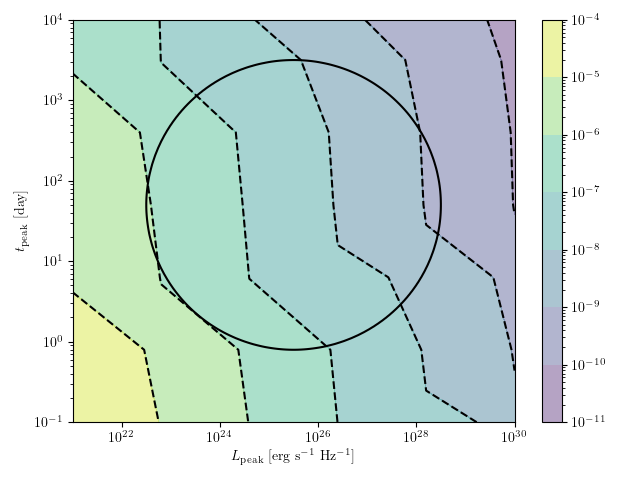

In [11]:
ga_ref = 1e-10
mode = 'Lpk-tpk'
run_id = rec_dct[mode]

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_sn.txt' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',').reshape(-1)

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_mesh = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%s_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_mesh = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 
ga_reach_mesh = ga_reach_flat.reshape(x_mesh.shape)

# plot
plt.subplots()
cs = plt.contourf(x_mesh, y_mesh, 
                  ga_reach_mesh, 
                  alpha=0.4, 
                  locator=ticker.LogLocator())
plt.colorbar(cs)
plt.contour(x_mesh, y_mesh, 
            ga_reach_mesh, 
            colors=['k'], 
            linestyles=['--'],
            locator=ticker.LogLocator())



#L_peak_Biet = 10**(25.5+1.6*2.)
# plt.vlines([10**(ct._mu_log10_Lpk_ - 2 * ct._sig_log10_Lpk_), 10**(ct._mu_log10_Lpk_ + 2 * ct._sig_log10_Lpk_)], 0.1, 1e6, ls='-', color='C0')
L_Biet_arr = np.logspace(ct._mu_log10_Lpk_ - 2 * ct._sig_log10_Lpk_,
                         ct._mu_log10_Lpk_ + 2 * ct._sig_log10_Lpk_, 
                         100)
t_Biet_arr = np.logspace(ct._mu_log10_tpk_ - 2 * ct._sig_log10_tpk_,
                         ct._mu_log10_tpk_ + 2 * ct._sig_log10_tpk_, 
                         100)
L_Biet_mesh, t_Biet_mesh = np.meshgrid(L_Biet_arr, t_Biet_arr, indexing='ij')
L_Biet_flat, t_Biet_flat = L_Biet_mesh.reshape(-1), t_Biet_mesh.reshape(-1)
sigma_flat = []
for i in range(len(L_Biet_flat)):
    L = L_Biet_flat[i]
    t = t_Biet_flat[i]
    sigma = np.sqrt((np.log10(L) - ct._mu_log10_Lpk_)**2/ct._sig_log10_Lpk_**2 + (np.log10(t) - ct._mu_log10_tpk_)**2/ct._sig_log10_tpk_**2)
    sigma_flat.append(sigma)

sigma_mesh = np.array(sigma_flat).reshape(L_Biet_mesh.shape)
plt.contour(L_Biet_mesh, t_Biet_mesh, sigma_mesh, colors=['k'], linestyles=['-'], levels=[2])
    
    
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e21, 1e30)
plt.ylim(0.1, 1e4)
# plt.title(title, fontdict={'size':15})
plt.xlabel(r'$L_{\rm peak}$ [erg s$^{-1}$ Hz$^{-1}$]')
plt.ylabel(r'$t_{\rm peak}$ [day]')
plt.tight_layout()

path = '../plots/projection_case1_Lpk_tpk_scan.pdf'
plt.savefig(path)

In [12]:
# run_id = '603cb2af-02e5-4572-9f25-26ac0fc0a49e'
# #run_id = rec_dct['Lpk-tpk']
# ga_ref = 1e-10
# mode = 'Lpk-tpk'

# # import results
# path = '../output/custom_snr/%s/' %mode
# name = 'run_%s_sn.txt' %run_id
# file_list = glob(os.path.join(path,name))
# if len(file_list) > 1:
#     print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
# target = file_list[0]
# snr_flat = np.loadtxt(target, delimiter=',').reshape(-1)

# # import grid
# path = '../output/custom_snr/%s/' %mode
# name = 'run_%s_y.txt' %run_id
# target = glob(os.path.join(path,name))[0]
# y_mesh = np.loadtxt(target, delimiter=',')

# path = '../output/custom_snr/%s/' %mode
# name = 'run_%s_x.txt' %run_id
# target = glob(os.path.join(path,name))[0]
# x_mesh = np.loadtxt(target, delimiter=',')

# # compute reach 
# ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 
# ga_reach_mesh = ga_reach_flat.reshape(x_mesh.shape)

# # plot
# plt.subplots()
# cs = plt.contourf(x_mesh, y_mesh, ga_reach_mesh, alpha=0.4, locator=ticker.LogLocator())
# plt.colorbar(cs)
# plt.contour(x_mesh, y_mesh, ga_reach_mesh, colors=['k'], linestyles=['--'], locator=ticker.LogLocator())



# #L_peak_Biet = 10**(25.5+1.6*2.)
# # plt.vlines([10**(ct._mu_log10_Lpk_ - 2 * ct._sig_log10_Lpk_), 10**(ct._mu_log10_Lpk_ + 2 * ct._sig_log10_Lpk_)], 0.1, 1e6, ls='-', color='C0')
# L_Biet_arr = np.logspace(ct._mu_log10_Lpk_ - 2 * ct._sig_log10_Lpk_, ct._mu_log10_Lpk_ + 2 * ct._sig_log10_Lpk_, 100)
# t_Biet_arr = np.logspace(ct._mu_log10_tpk_ - 2 * ct._sig_log10_tpk_, ct._mu_log10_tpk_ + 2 * ct._sig_log10_tpk_, 100)
# L_Biet_mesh, t_Biet_mesh = np.meshgrid(L_Biet_arr, t_Biet_arr, indexing='ij')
# L_Biet_flat, t_Biet_flat = L_Biet_mesh.reshape(-1), t_Biet_mesh.reshape(-1)
# sigma_flat = []
# for i in range(len(L_Biet_flat)):
#     L = L_Biet_flat[i]
#     t = t_Biet_flat[i]
#     sigma = np.sqrt((np.log10(L) - ct._mu_log10_Lpk_)**2/ct._sig_log10_Lpk_**2 + (np.log10(t) - ct._mu_log10_tpk_)**2/ct._sig_log10_tpk_**2)
#     sigma_flat.append(sigma)

# sigma_mesh = np.array(sigma_flat).reshape(L_Biet_mesh.shape)
# plt.contour(L_Biet_mesh, t_Biet_mesh, sigma_mesh, colors=['k'], linestyles=['-'], levels=[2])
    
    
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(1e21, 1e30)
# plt.ylim(0.1, 1e4)
# # plt.title(title, fontdict={'size':15})
# plt.xlabel(r'$L_{\rm peak}$ [erg s$^{-1}$ Hz$^{-1}$]')
# plt.ylabel(r'$t_{\rm peak}$ [day]')
# plt.tight_layout()

# path = '../plots/projection_case1_Lpk_tpk_scan.pdf'
# plt.savefig(path)

### CASE 2: $t_{trans}/t_{peak}$ vs $t_0$

`python ./run_custom.py --run 0 --nuB 5 --Nsteps 30 r-tsig --Lpk 3.16e28 --tpk 50.1 --dist 0.5 --long_lat 178 0`

<IPython.core.display.Javascript object>


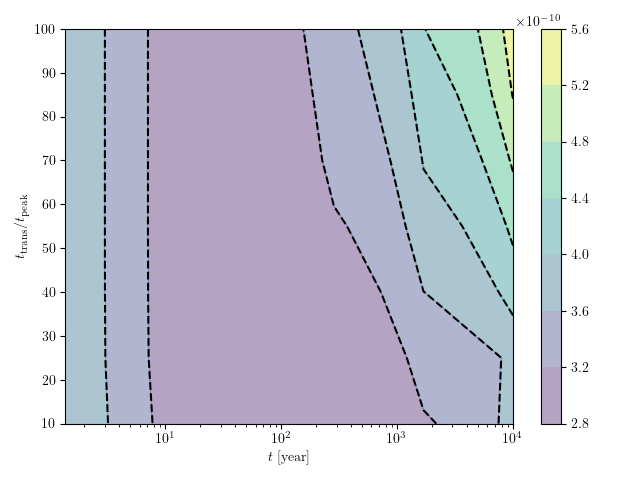

In [13]:
ga_ref = 1e-10
mode = 'tsig-r'
run_id = rec_dct[mode]

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_sn.txt' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_mesh = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%s_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_mesh = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 
ga_reach_mesh = ga_reach_flat.reshape(x_mesh.shape)

# plot
plt.subplots()
cs = plt.contourf(x_mesh, y_mesh, ga_reach_mesh, alpha=0.4)
plt.colorbar(cs)
plt.contour(x_mesh, y_mesh, ga_reach_mesh, colors=['k'], linestyles=['--'])
plt.xscale('log')

plt.xlabel(r'$t$ [year]')
plt.ylabel(r'$t_{\rm trans}/t_{\rm peak}$')
plt.tight_layout()
path = '../plots/projection_case2_r-tsig.pdf'
plt.savefig(path)

### CASE 3: ttrans vs $t_{extra}$
    
`python ./run_custom.py --run 0 --nuB 5 --Nsteps 30 r-tex --Lpk 3.16e28 --tpk 50.1 --dist 0.5 --long_lat 178 0`

<IPython.core.display.Javascript object>


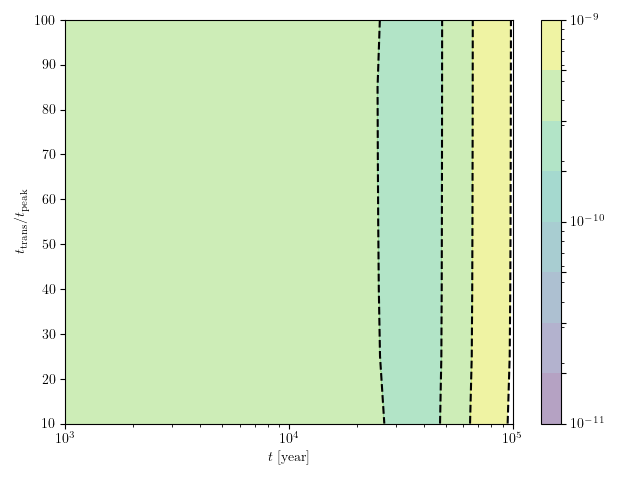

In [14]:
ga_ref = 1e-10
mode = 'tex-r'
run_id = rec_dct[mode]

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_sn.txt' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_mesh = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%s_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_mesh = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 
ga_reach_mesh = ga_reach_flat.reshape(x_mesh.shape)

# plot
plt.subplots()
cs = plt.contourf(x_mesh, y_mesh, (ga_reach_mesh), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 9))
plt.colorbar(cs)
plt.contour(x_mesh, y_mesh, (ga_reach_mesh), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 9))
# plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e4, 1e5)

plt.xlabel(r'$t$ [year]')
plt.ylabel(r'$t_{\rm trans}/t_{\rm peak}$')
plt.tight_layout()
path = '../plots/projection_case3_r_tex_scan.pdf'
plt.savefig(path)

### CASE 4: $\ell$ vs $D$
    
`python ./run_custom.py --run 0 --nuB 5 --Nsteps 100 l-D --Lpk 3.16e28 --tpk 50.1 --tt_ratio 30 --t0 1e4 --t_extra 4e4 --lat 0`

<IPython.core.display.Javascript object>


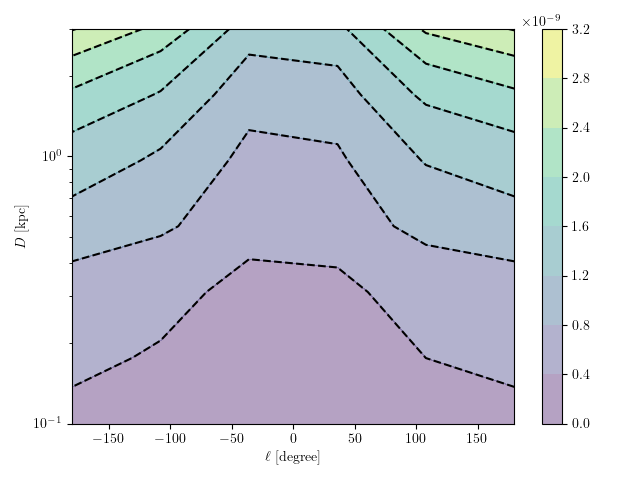

In [15]:
ga_ref = 1e-10
mode = 'l-D'
run_id = rec_dct[mode]

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_sn.txt' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_mesh = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%s_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_mesh = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 
ga_reach_mesh = ga_reach_flat.reshape(x_mesh.shape)

# plot
plt.subplots()
cs = plt.contourf(x_mesh-180, y_mesh, (ga_reach_flat), alpha=0.4)#, locator=ticker.LogLocator())

plt.colorbar(cs)
plt.contour(x_mesh-180, y_mesh, (ga_reach_flat), colors=['k'], linestyles=['--'])#, locator=ticker.LogLocator())
# plt.yscale('log')
plt.yscale('log')

plt.xlabel(r'$\ell$ [degree]')
plt.ylabel(r'$D$ [kpc]')
plt.tight_layout()
path = '../plots/projection_case4_l_D_scan.pdf'
plt.savefig(path)

### CASE 5: $\ell$ vs $b$
    
`python ./run_custom.py --run 0 --nuB 5 --Nsteps 30 l-b --Lpk 3.16e28 --tpk 50.1 --dist 0.5 --tt_ratio 30 --t0 1e4 --t_extra 4e4`

In [144]:
#run_id = "14f4dbea-3a96-4bd6-b0d5-3af2d4063f33"

<IPython.core.display.Javascript object>


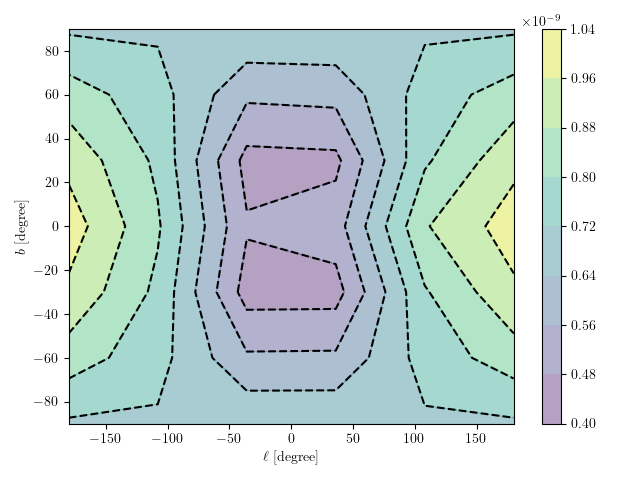

In [16]:
ga_ref = 1e-10
mode = 'l-b'
run_id = rec_dct[mode]

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_sn.txt' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_mesh = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%s_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_mesh = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 
ga_reach_mesh = ga_reach_flat.reshape(x_mesh.shape)

# plot
plt.subplots()
cs = plt.contourf(x_mesh-180, -y_mesh, (ga_reach_flat), alpha=0.4)#, locator=ticker.LogLocator())
plt.colorbar(cs)
plt.contour(x_mesh-180, -y_mesh, (ga_reach_flat), colors=['k'], linestyles=['--'])#, locator=ticker.LogLocator())
# plt.yscale('log')
# plt.xscale('log')

plt.ylabel(r'$b$ [degree]')
plt.xlabel(r'$\ell$ [degree]')
plt.tight_layout()
path = '../plots/projection_case5_l_b_scan.pdf'
plt.savefig(path)

### CASE 6: t-D
`python ./run_custom.py --run 0 --nuB 5 --Nsteps 30 D-t --Lpk 3.16e28 --tpk 50.1 --tt_ratio 30 -lb 178 0`

<IPython.core.display.Javascript object>


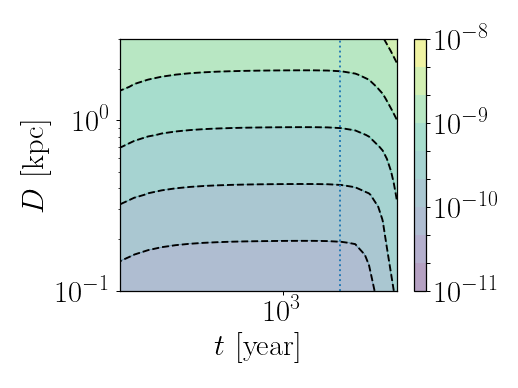

In [324]:
#run_id = 3
ga_ref = 1e-10
mode = 't-D'
run_id = rec_dct3[mode]

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_sn.txt' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_mesh = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%s_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_mesh = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 
ga_reach_mesh = ga_reach_flat.reshape(x_mesh.shape)

# plot
plt.subplots()
cs = plt.contourf(x_mesh, y_mesh, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.colorbar(cs)
plt.contour(x_mesh, y_mesh, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.yscale('log')
plt.xscale('log')
plt.vlines(1e4, 1e-1, 3, ls=':')

plt.xlabel(r'$t$ [year]')
plt.ylabel(r'$D$ [kpc]')
plt.tight_layout()
path = '../plots/projection_case6_D_t_scan.pdf'
plt.savefig(path)

<IPython.core.display.Javascript object>


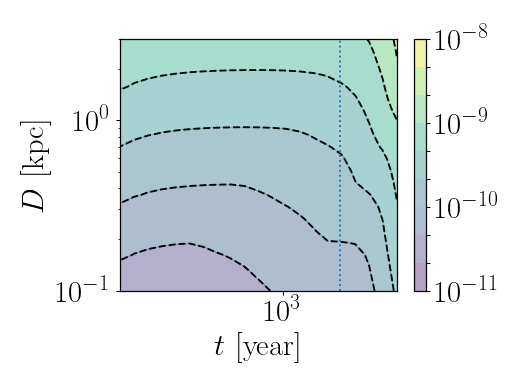

In [327]:
#run_id = 3
ga_ref = 1e-10
mode = 't-D'
run_id = rec_dct2[mode]

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_sn.txt' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_mesh = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%s_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_mesh = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 
ga_reach_mesh = ga_reach_flat.reshape(x_mesh.shape)

# plot
plt.subplots()
cs = plt.contourf(x_mesh, y_mesh, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.colorbar(cs)
plt.contour(x_mesh, y_mesh, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.yscale('log')
plt.xscale('log')
plt.vlines(1e4, 1e-1, 3, ls=':')

plt.xlabel(r'$t$ [year]')
plt.ylabel(r'$D$ [kpc]')
plt.tight_layout()
path = '../plots/projection_case6_D_t_scan.pdf'
plt.savefig(path)

In [328]:
1e-3 / ct._arcmin_over_radian_

3.4377467707849396

<IPython.core.display.Javascript object>


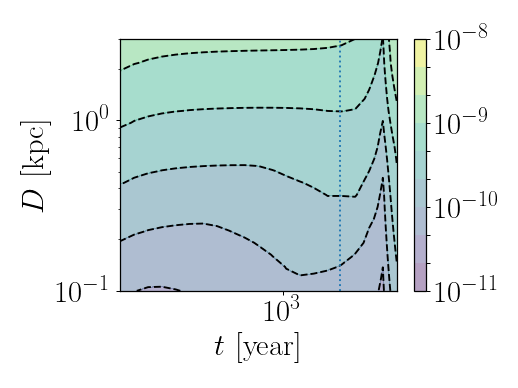

In [318]:
#run_id = 3
ga_ref = 1e-10
mode = 't-D'
run_id = rec_dct[mode]

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_sn.txt' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_mesh = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%s_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_mesh = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 
ga_reach_mesh = ga_reach_flat.reshape(x_mesh.shape)

# plot
plt.subplots()
cs = plt.contourf(x_mesh, y_mesh, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.colorbar(cs)
plt.contour(x_mesh, y_mesh, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -8, 10))
plt.yscale('log')
plt.xscale('log')
plt.vlines(1e4, 1e-1, 3, ls=':')

plt.xlabel(r'$t$ [year]')
plt.ylabel(r'$D$ [kpc]')
plt.tight_layout()
path = '../plots/projection_case6_D_t_scan.pdf'
plt.savefig(path)

### CASE 7: $\ell$-t
`python ./run_custom.py --run 0 --nuB 5 --Nsteps 100 l-t --Lpk 3.16e28 --tpk 50.1 --tt_ratio 30 -D 0.5 -b 0`

<IPython.core.display.Javascript object>


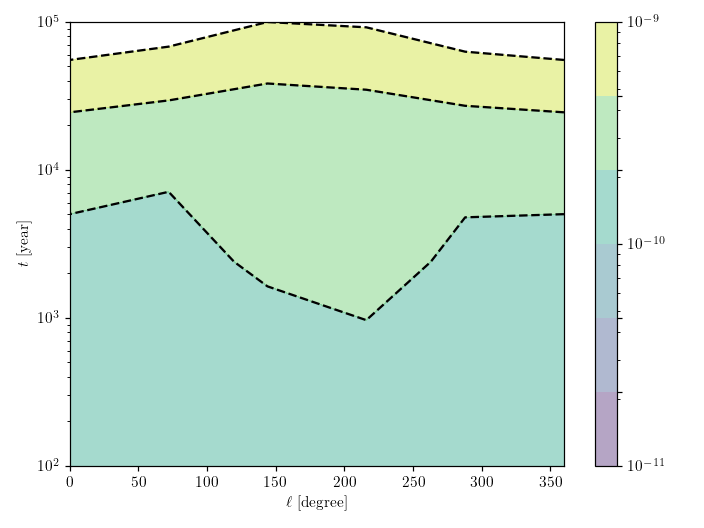

In [40]:
ga_ref = 1e-10
mode = 'l-t'
run_id = rec_dct[mode]

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_sn.txt' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_mesh = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%s_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_mesh = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 
ga_reach_mesh = ga_reach_flat.reshape(x_mesh.shape)


# plot
plt.subplots()
cs = plt.contourf(x_mesh, y_mesh, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 7))
plt.colorbar(cs)
plt.contour(x_mesh, y_mesh, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 7))
#plt.yscale('log')
plt.yscale('log')
plt.ylim(1e2, 1e5)

plt.xlabel(r'$\ell$ [degree]')
plt.ylabel(r'$t$ [year]')
plt.tight_layout()
path = '../plots/projection_case7_l_t_scan.pdf'
plt.savefig(path)

### CASE 8: $b$-t
`python ./run_custom.py --run 0 --nuB 5 --Nsteps 100 b-t --Lpk 3.16e28 --tpk 50.1 --tt_ratio 30 -D 0.5 -l 178`

<IPython.core.display.Javascript object>


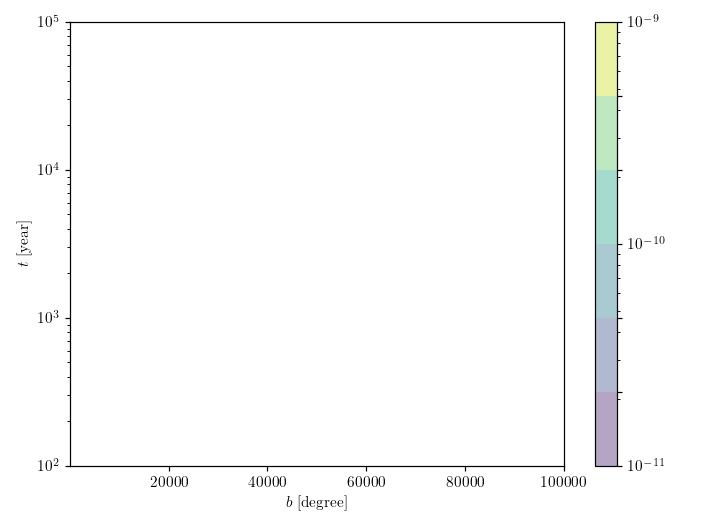

In [49]:
ga_ref = 1e-10
mode = 't-b'
run_id = rec_dct[mode]

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_sn.txt' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_mesh = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%s_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_mesh = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 


# plot
plt.subplots()
cs = plt.contourf(x_mesh, y_mesh, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 7))
plt.colorbar(cs)
plt.contour(x_mesh, y_mesh, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-11, -9, 7))
#plt.yscale('log')
plt.yscale('log')
plt.ylim(1e2, 1e5)

plt.ylabel(r'$t$ [year]')
plt.xlabel(r'$b$ [degree]')
plt.tight_layout()
path = '../plots/projection_case8_b_t_scan.pdf'
plt.savefig(path)

### CASE 9: $t-S_0$
`python ./run_custom.py --run 1 --nuB 8 --Nsteps 30 t-S0 --tpk 50.1 --tt_ratio 30 -D 0.5 -lb 175 0`

<IPython.core.display.Javascript object>


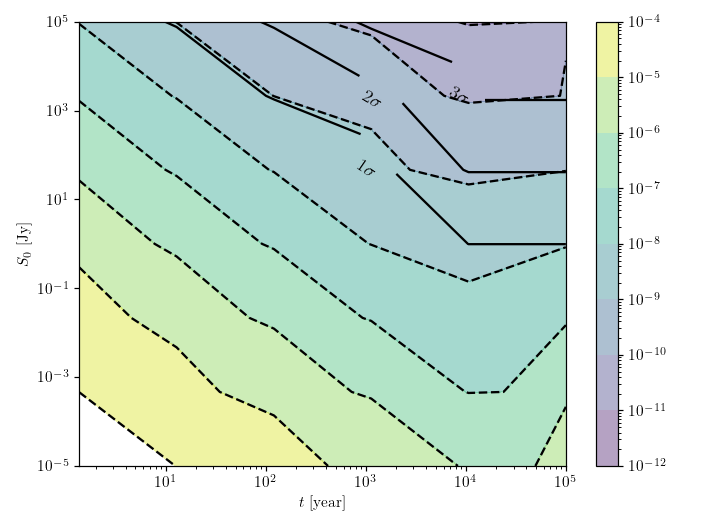

In [48]:
ga_ref = 1e-10
mode = 't-S0'
run_id = rec_dct[mode]

# import results
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_sn.txt' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
snr_flat = np.loadtxt(target, delimiter=',')

# import grid
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_y.txt' %run_id
target = glob(os.path.join(path,name))[0]
y_mesh = np.loadtxt(target, delimiter=',')

path = '../output/custom_snr/%s/' %mode
name = 'run_%s_x.txt' %run_id
target = glob(os.path.join(path,name))[0]
x_mesh = np.loadtxt(target, delimiter=',')

# compute reach 
ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 

# plot
plt.subplots()
cs = plt.contourf(x_mesh, y_mesh, (ga_reach_flat), alpha=0.4, locator=ticker.LogLocator(), levels=np.logspace(-12, -4, 9))
plt.colorbar(cs)
plt.contour(x_mesh, y_mesh, (ga_reach_flat), colors=['k'], linestyles=['--'], locator=ticker.LogLocator(), levels=np.logspace(-12, -4, 9))
#plt.yscale('log')
plt.yscale('log')
plt.xscale('log')




# Bietenholz contours
path = '../output/custom_snr/%s/' %mode
name = 'run_%s_blob.txt' %run_id
file_list = glob(os.path.join(path,name))
if len(file_list) > 1:
    print('warning!!! multiple runs are found with the same runid. This could be problematic. Choosing the first one.')
target = file_list[0]
Lpk_Biet_flat = np.loadtxt(target, delimiter=',')
sigma_Biet_flat = (np.log10(Lpk_Biet_flat) - ct._mu_log10_Lpk_)/ct._sig_log10_Lpk_
cs2 = plt.contour(x_mesh, y_mesh, sigma_Biet_flat, levels=[1,2,3], colors=['k'])

# inline labeling
fmt = {}
strs = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
for l, s in zip(cs2.levels, strs):
    fmt[l] = s
plt.clabel(cs2, cs2.levels, inline=True, fmt=fmt, fontsize=12)


plt.xlabel(r'$t$ [year]')
plt.ylabel(r"$S_0$ [Jy]")
plt.tight_layout()
path = '../plots/projection_case9_t_S0_scan.pdf'
plt.savefig(path)

### generic slicing

In [411]:
class Container():
    pass

# when a direction is scanned over, 
# the conflicting params are not loaded

rn.args = Container()

# run:
rn.args.Nsteps = 40
rn.args.verbose = 0

# SNR:
#rn.args.t_signal = 1e4#30
#rn.args.S0 = 1e5
#rn.args.t_extra = 4e4
rn.args.tage = 5e5
rn.args.coords = (175, 0)
rn.args.distance = 0.5
rn.args.sr = None
rn.args.alpha = 0.5

# light curve
rn.args.tt_ratio = 30
rn.args.nuB = 8
rn.args.Lpk = 10**(ct._mu_log10_Lpk_ + 1.414*ct._sig_log10_Lpk_)
rn.args.tpk = 10**(ct._mu_log10_tpk_ + 1.414*ct._sig_log10_tpk_)

run = rn.Run()


#rec_dct = run('L peak Bietenholz, t peak', run_id="test")
#rec_dct = run('L peak Bietenholz, t trans over t peak', run_id="test")

In [412]:
todo_arr = []
for i, _ in enumerate(slicing_direction_arr):
    for j in range(i):
        todo_arr.append((i,j))

In [413]:
from multiprocessing import Pool

slicing_direction_arr = ["L peak Bietenholz",
                       "t peak",
                       "t trans over t peak",
                       "t age total",
                       "galaxy l",
                       "galaxy b",
                       "distance"
                       ]

run = rn.Run()

# parallelization
def run_time_wrapper(index):
    i,j = index
    mode_i = slicing_direction_arr[i]
    mode_j = slicing_direction_arr[j]
    if mode_i != mode_j:
        rec_dct = run('%s, %s' %(mode_i, mode_j), 
                      run_id="test", 
                      verbose=0)
        return rec_dct
        
todo_arr = []
for i, _ in enumerate(slicing_direction_arr):
    for j in range(i):
        todo_arr.append((i,j))

with Pool() as p:
    res_arr = p.map(run_time_wrapper, todo_arr)


# save record, res_arr -> rec_dct
rec_dct = {}
for entry in res_arr:
    rec_dct.update(entry)
rec_dct

t peak, L peak Bietenholz:test
t trans over t peak, t peak:test
t age total, t peak:test
t trans over t peak, L peak Bietenholz:test
t age total, L peak Bietenholz:test
galaxy l, L peak Bietenholz:test
t age total, t trans over t peak:test




galaxy l, t peak:test




galaxy l, t trans over t peak:test

galaxy l, t age total:test

galaxy b, L peak Bietenholz:test

galaxy b, t peak:test

galaxy b, t trans over t peak:test

galaxy b, t age total:test

galaxy b, galaxy l:test
distance, L peak Bietenholz:test


distance, t peak:test

distance, t trans over t peak:test

distance, t age total:test

distance, galaxy l:test

distance, galaxy b:test



{'t peak, L peak Bietenholz': 'test',
 't trans over t peak, L peak Bietenholz': 'test',
 't trans over t peak, t peak': 'test',
 't age total, L peak Bietenholz': 'test',
 't age total, t peak': 'test',
 't age total, t trans over t peak': 'test',
 'galaxy l, L peak Bietenholz': 'test',
 'galaxy l, t peak': 'test',
 'galaxy l, t trans over t peak': 'test',
 'galaxy l, t age total': 'test',
 'galaxy b, L peak Bietenholz': 'test',
 'galaxy b, t peak': 'test',
 'galaxy b, t trans over t peak': 'test',
 'galaxy b, t age total': 'test',
 'galaxy b, galaxy l': 'test',
 'distance, L peak Bietenholz': 'test',
 'distance, t peak': 'test',
 'distance, t trans over t peak': 'test',
 'distance, t age total': 'test',
 'distance, galaxy l': 'test',
 'distance, galaxy b': 'test'}

### plot grid

In [541]:
def insert_plot(mode, ax, data_log, levels=None, num_of_lvl=None, verbose=0):
    ga_ref = 1e-10
    
    run_id = rec_dct[mode]

    # import results
    path = '../output/custom_snr/%s/' %mode
    name = 'run_%s_sn.txt' %run_id
    file_list = glob(os.path.join(path,name))
    if len(file_list) > 1:
        print('warning!!! multiple runs are found with the same \
    runid. This could be problematic. Choosing the first one.')
    target = file_list[0]
    snr_flat = np.loadtxt(target, delimiter=',')

    # import grid
    path = '../output/custom_snr/%s/' %mode
    name = 'run_%s_y.txt' %run_id
    target = glob(os.path.join(path,name))[0]
    y_mesh = np.loadtxt(target, delimiter=',')

    path = '../output/custom_snr/%s/' %mode
    name = 'run_%s_x.txt' %run_id
    target = glob(os.path.join(path,name))[0]
    x_mesh = np.loadtxt(target, delimiter=',')

    # compute reach 
    ga_reach_flat = ec.ga_reach(2, snr_flat, ga_ref) 
    ga_reach_mesh = ga_reach_flat.reshape(x_mesh.shape)

    # special pre-processing
    mode_arr = mode.split(",")
    ##  (age)
    for i, x in enumerate(mode_arr):
        mode_arr[i] = x.strip()
    if mode_arr[0] == "t age total":
        x_mesh = x_mesh/1e4
        if verbose > 0:
            print("y scaling")
            print(mode)
    if mode_arr[1] == "t age total":
        y_mesh = y_mesh/1e4    
        if verbose > 0:
            print("x axis scaling")
            print(mode)
    
    ## l
    if mode_arr[0] == "galaxy l":
        x_mesh = x_mesh - 180.
    if mode_arr[1] == "galaxy l":
        y_mesh = y_mesh - 180.
        
    ## b
    if mode_arr[0] == "galaxy b":
        x_mesh = -1*x_mesh
    if mode_arr[1] == "galaxy b":
        y_mesh = -1*y_mesh
        
        
    
    # plot range
    ymin, ymax = ax.set_ylim([min(x_mesh[:,0]), max(x_mesh[:,0])])
    xmin, xmax = ax.set_xlim([min(y_mesh[0]), max(y_mesh[0])])

    # determine levels
    if (levels is None) and (num_of_lvl is not None):
        data_min = min(ga_reach_mesh.reshape(-1)*1e10)
        data_max = max(ga_reach_mesh.reshape(-1)*1e10)
        levels = np.logspace(np.log10(data_min), np.log10(data_max), num_of_lvl)
    
    # plot
    if data_log:
        ax.contourf(y_mesh.T, 
                     x_mesh.T, 
                     ga_reach_mesh.T*1e10, 
                     alpha=0.4, 
                     locator=ticker.LogLocator(),
                     levels=levels,
                     extend="none")
        cs = ax.contour(y_mesh.T, 
                     x_mesh.T, 
                     ga_reach_mesh.T*1e10, 
                     alpha=0.4, 
                     #colors=['k'],
                     locator=ticker.LogLocator(),
                     levels=levels,
                     extend="none")        
        clabel = ax.clabel(cs, inline=False, inline_spacing=10, fontsize=10, fmt='%.0e', colors='k')
        use_log = True
        
    else:
        ax.contourf(y_mesh.T, 
                     x_mesh.T, 
                     ga_reach_mesh.T*1e10, 
                     alpha=0.4,
                     levels=levels,
                     extend="none")
        cs=ax.contour(y_mesh.T, 
                     x_mesh.T, 
                     ga_reach_mesh.T*1e10, 
                     alpha=0.4,
                     #colors=['k'],
                     levels=levels,
                     extend="none")
        
        clabel = ax.clabel(cs, inline=False, inline_spacing=10, fontsize=10, fmt='%.0f', colors='k')
        use_log = False

    for clabel_i in clabel:
        if verbose > 0:
            print(clabel_i)
        clabel_i.set_alpha(1)            
    
    if verbose > 0:
        print("ylim set to %.1e %.1e" %(ymin, ymax))
        print("xlim set to %.1e %.1e" %(xmin, xmax))
        print("contour levels are %s" %(cs.levels))
    return clabel

<IPython.core.display.Javascript object>


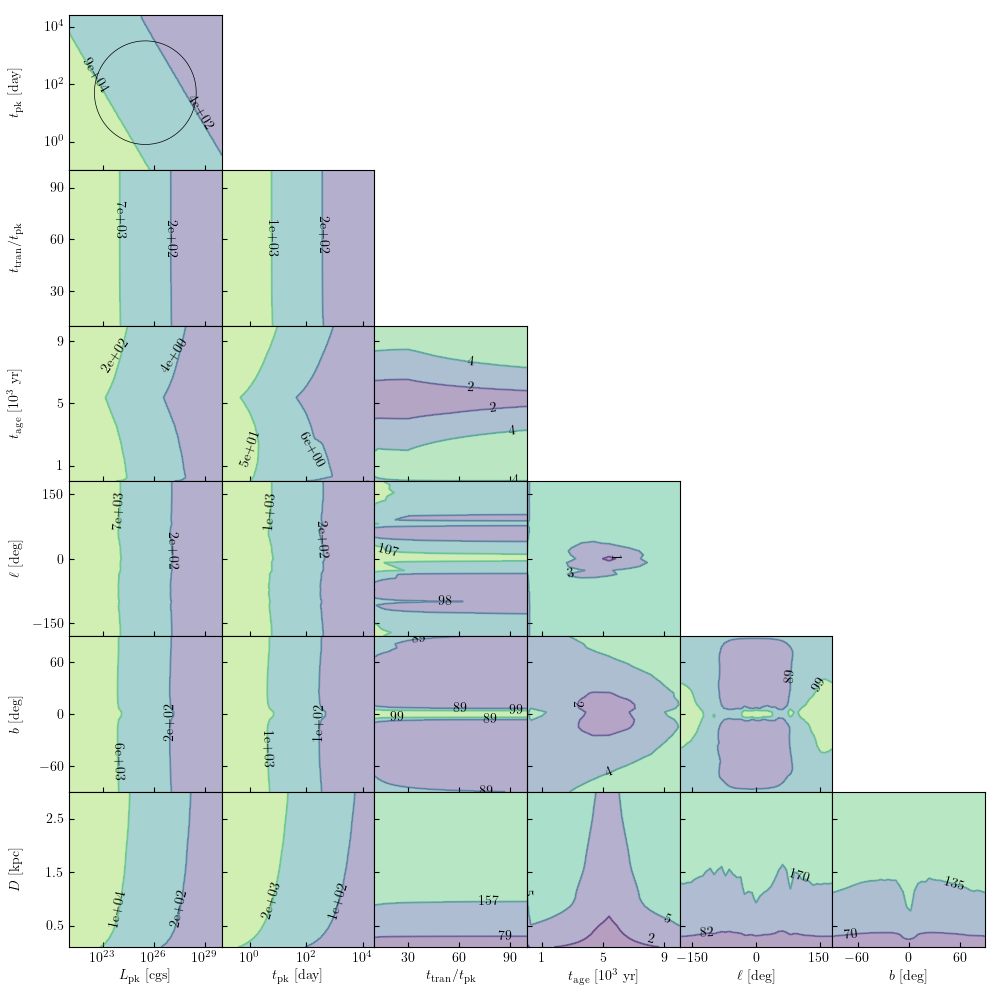

In [561]:
verbose = 0

# labeling
label_arr = [r"$L_{\rm pk}$ [cgs]",
            r"$t_{\rm pk}$ [day]",
            r"$t_{\rm tran}/t_{\rm pk}$",
            r"$t_{\rm age}$ [$10^3$ yr]",
            r"$\ell$ [deg]",
            r"$b$ [deg]",
            r"$D$ [kpc]"
                       ]

# scale
log_scale_arr = ["L peak Bietenholz",
                       "t peak"
                       ]

lin_scale_arr = ["t trans over t peak",
                 "galaxy l",
                       "galaxy b",
                       "distance",
                       "t age total"
                       ]
ticks_dct = {
                "L peak Bietenholz": [1e23, 1e26, 1e29],
                "t peak": [1, 100, 1e4],
                "t trans over t peak":[30, 60, 90],
                "galaxy l":[-150, 0, 150],
                "galaxy b":[-60, 0, 60],
                "distance":[0.5, 1.5, 2.5],
                "t age total":[1, 5, 9]
}

levels = None #np.linspace(1, 1000, 10)
num_of_lvl = 4

dim = len(slicing_direction_arr) 

fig = plt.figure(figsize=(10,10), constrained_layout=False)
gs = fig.add_gridspec(dim-1, dim-1, hspace=0, wspace=0)
# add all subplots
# axs = gs.subplots(sharex=True, sharey=True)
axes = np.zeros((dim, dim), dtype=object)
clabels = np.zeros((dim, dim), dtype=object)

for i,j in todo_arr:
    if verbose > 0:
        print(i,j)
    axes[i,j] = fig.add_subplot(gs[i-1,j])
    ax = axes[i,j]
    mode = "%s, %s" %(slicing_direction_arr[i], slicing_direction_arr[j])
    # if any either the axis is log scale, use log scale for data 
    data_log = False
    if slicing_direction_arr[i] in log_scale_arr:
        ax.set_yscale('log')
        data_log = True
    else:
        pass
    
    if slicing_direction_arr[j] in log_scale_arr:
        ax.set_xscale('log')
        data_log = True
    else:
        pass
    if verbose > 0:
        print(mode)
    clabels[i,j] = insert_plot(mode, ax, data_log, num_of_lvl=num_of_lvl, verbose=verbose)    
    
    # set tick
    ax.set_xticks(ticks_dct[slicing_direction_arr[j]])
    ax.set_yticks(ticks_dct[slicing_direction_arr[i]])
    
    # set y label
    if j == 0:
        ax.set_ylabel(label_arr[i])
        ax.tick_params(labelleft=True, direction="in")
        ax.get_yaxis().set_label_coords(-0.3, 0.5)
    else:
        ax.tick_params(labelleft=False, direction="in")
    ax.set_xlabel(label_arr[j])    
    
    
    
# # Hide x labels and tick labels for all but bottom plot.
for ax in axs.flat:
    try:
        ax.label_outer()
    except AttributeError:
        pass
    
#fig.suptitle('SNR property slicing')



# add extra post-processing say Bietenholz circle etc.
L_Biet_arr = np.logspace(ct._mu_log10_Lpk_ - 2 * ct._sig_log10_Lpk_,
                         ct._mu_log10_Lpk_ + 2 * ct._sig_log10_Lpk_, 
                         100)
t_Biet_arr = np.logspace(ct._mu_log10_tpk_ - 2 * ct._sig_log10_tpk_,
                         ct._mu_log10_tpk_ + 2 * ct._sig_log10_tpk_, 
                         100)
L_Biet_mesh, t_Biet_mesh = np.meshgrid(L_Biet_arr, t_Biet_arr, indexing='ij')
L_Biet_flat, t_Biet_flat = L_Biet_mesh.reshape(-1), t_Biet_mesh.reshape(-1)
sigma_flat = []
for i in range(len(L_Biet_flat)):
    L = L_Biet_flat[i]
    t = t_Biet_flat[i]
    sigma = np.sqrt((np.log10(L) - ct._mu_log10_Lpk_)**2/ct._sig_log10_Lpk_**2 + (np.log10(t) - ct._mu_log10_tpk_)**2/ct._sig_log10_tpk_**2)
    sigma_flat.append(sigma)

sigma_mesh = np.array(sigma_flat).reshape(L_Biet_mesh.shape)
axes[1,0].contour(L_Biet_mesh, t_Biet_mesh, sigma_mesh, colors=['k'], linestyles=['-'], levels=[2], linewidths=[0.5])


# DONE: the color scale 
# DONE: color bar on the side
plt.tight_layout()

In [568]:
# post-process (inline) clabels

clabel = clabels[1,0]
clabel[0].set_x(0.5e29)
clabel[0].set_y(10)

clabel = clabels[3,0]
for clabel_i in clabel:
    clabel_i.set_y(8.)
    
clabel = clabels[3,1]
for clabel_i in clabel:
    clabel_i.set_y(2.)    

clabel = clabels[6,3]
clabel[0].set_y(0.25)

clabel = clabels[4,2]
clabel[1].set_y(1e100)
clabel[2].set_y(1e100)
clabel[3].set_y(1e100)
clabel[4].set_y(1e100)
clabel[6].set_y(1e100)

clabel = clabels[4,3]
clabel[1].set_y(1e100)

clabel = clabels[5,3]
clabel[0].set_y(1e100)
clabel[1].set_y(1e100)
clabel[4].set_y(1e100)

clabel = clabels[5,4]
clabel[0].set_y(1e100)
clabel[2].set_y(1e100)
clabel[4].set_y(1e100)

plt.savefig('../plots/property_slicing.pdf')

In [566]:
clabel = clabels[5,4]

In [567]:
for x in clabel:
    print(x)

Text(-9.000000000000227, -6.36893456947729, '89')
Text(80.99999999999955, 43.59305649339694, '89')
Text(-135.00000000000045, 8.594464457669062, '99')
Text(148.208740157208, 32.926829268292636, '99')
Text(8.999999999999545, -4.347080552069599, '99')


### check coordinates

In [80]:
from astropy import units as u
from astropy.coordinates import SkyCoord
#from astropy.coordinates import ICRS, Galactic
#c = SkyCoord(l=6.4*u.degree, b=-0.1*u.degree, frame='galactic')
c = SkyCoord(l=64*u.degree, b=-0.1*u.degree, frame='galactic')
c.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (298.31741262, 27.28953632)>

In [202]:
c = SkyCoord(l=0*u.degree, b=0*u.degree, frame='galactic')
c.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (266.40498829, -28.93617776)>

In [203]:
c = SkyCoord(l=180*u.degree, b=0*u.degree, frame='galactic')
c.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (86.40498829, 28.93617776)>

In [205]:
c = SkyCoord(l=150*u.degree, b=0*u.degree, frame='galactic')
c.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (71.74356338, 45.24624231)>

In [210]:
c = SkyCoord(l=90*u.degree, b=0*u.degree, frame='galactic')
c.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (318.00438151, 48.32963721)>